## Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

## Import daily lessons data

In [4]:
# Specify directory where lessons data exists
lessons_directory = os.fsencode('daily_lessons')

In [5]:
# Define a function for retrieving all lessons data
def get_lessons_data(dir):
    
    # Initialize an empty list to store DataFrames
    lessons = []

    # Iterate over all daily lessons files
    for file in os.listdir(dir):
        
        file_name = os.fsdecode(file)
        
        # Check if the file is an Excel file
        if file_name.endswith('.xlsx'):
            temp_xlsx_file = 'daily_lessons/{}'.format(file_name)
            lessons_temp = pd.read_excel(temp_xlsx_file)
        else:
            continue
            
        # Append the DataFrame to the list
        lessons.append(lessons_temp)

    # Concatenate all DataFrames in the list into one DataFrame
    df_all_lessons = pd.concat(lessons, ignore_index=True)
    
    return df_all_lessons

In [6]:
# Define relevant data fields
relevant_cols = [
    'Start Date', 
    'Instructor Name', 
    'Start Time', 
    'End Time', 
    'Duration',
    'Group Variant', 
    'Activity Type',
    '_Level (Group)',
    '_Level (Guest)']

In [7]:
#['lesson_type', 'lesson_subtype', 'lesson_length'

In [8]:
# Retrieve data & restrict to relevant columns
df_all_lessons = get_lessons_data(lessons_directory)
df_all_lessons = df_all_lessons.loc[:, relevant_cols]

/tmp/ipykernel_2309/3257380539.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_lessons = pd.concat(lessons, ignore_index=True)


In [9]:
# Remove lessons not assigned to instructors
df_all_lessons = df_all_lessons[df_all_lessons['Instructor Name'] != '-']

## Generate new relevant columns from exisiting ones

In [11]:
# Define list containing all sub-codes corresponding to programs and schools
programs_and_schools =  ['camp', 'clinic', 'school', 'program', 'friday fun', 'mini mites', 'pd', 'rats', 'shred', 'warrior', 'mountain', 'progression']

In [12]:
# Define a function for extracting lesson types from strings in the column "Group Variant"
def extract_lesson_type(group_variant):

    if any(substr in group_variant.lower() for substr in programs_and_schools):
        return 'Schools & Programs'
    elif 'first time' in group_variant.lower():
        return 'First Time'
    elif 'group' in group_variant.lower():
        return 'Group'
    elif 'private' in group_variant.lower():
        return 'Private'
    elif 'terrain' in group_variant.lower():
        return 'Terrain Park'
    else:
        return None

In [13]:
# Define a function for extracting customer type from strings in the column "Group Variant"
def extract_customer_type(group_variant):

    if any(substr in group_variant.lower() for substr in programs_and_schools):
        return 'Schools & Programs'
    elif 'child' in group_variant.lower():
        return 'Child'
    elif 'adult' in group_variant.lower():
        return 'Adult'
    elif 'kinder' in group_variant.lower():
        return 'Kinder'
    elif 'family' in group_variant.lower():
        return 'Family'
    else:
        return None

In [14]:
# Define a function for extracting lesson lengths from strings in the column "Group Variant"
def extract_lesson_length(group_variant):

    if '1 hour' in group_variant.lower():
        return 1
    elif '2 hour' in group_variant.lower():
        return 2
    elif '3 hour' in group_variant.lower():
        return 3
    elif '4 hour' in group_variant.lower():
        return 4
    elif 'multi week' in group_variant.lower():
        return 2
    else:
        return None

In [15]:
# Define a function for imputing lesson lengths from Duration when lesson_length = None
def extract_null_lesson_length(duration):

    if duration == '2:00':
        return 2
    else:
        return 4

In [16]:
# Generate new columns
df_all_lessons['lesson_type'] = df_all_lessons['Group Variant'].apply(extract_lesson_type)
df_all_lessons['customer_type'] = df_all_lessons['Group Variant'].apply(extract_customer_type)
df_all_lessons['lesson_length'] = df_all_lessons['Group Variant'].apply(extract_lesson_length)
mask = df_all_lessons['lesson_length'].isnull()
df_all_lessons.loc[mask, 'lesson_length'] = df_all_lessons.loc[mask, 'Duration'].apply(extract_null_lesson_length)

## Clean up lessons data

In [18]:
# When 'group level' is missing, check if 'guest level' exists and import
mask = df_all_lessons['_Level (Group)'].isnull() & df_all_lessons['_Level (Guest)'].notnull()
df_all_lessons.loc[mask, '_Level (Group)'] = df_all_lessons.loc[mask, '_Level (Guest)']
# If no information, assume Level 1
df_all_lessons.loc[df_all_lessons['_Level (Group)'].isnull(), '_Level (Group)'] = 'Level 1'

In [19]:
# Define function to extract integers from strings in '_Level (Group)' column & apply
def extract_integers(s):
    return int(''.join(filter(str.isdigit, s)))

# Apply the function to the column 'Level'
df_all_lessons['_Level (Group)'] = df_all_lessons['_Level (Group)'].apply(extract_integers)

In [20]:
# Fix lessons with incorrect end times
df_all_lessons.loc[df_all_lessons['Duration'] == '4:00', 'End Time'] = '15:00'

In [21]:
# Keep and re-name relevant level columns
df_all_lessons.drop(columns=['_Level (Guest)', 'Group Variant', 'Duration'], inplace=True)
df_all_lessons.rename(columns={'_Level (Group)':'Level', 'Activity Type':'Activity', 'Start Date':'Date'}, inplace=True)

In [22]:
# Filter out duplicate entries for lessons (due to original table being a customer table)
dupe_cols = df_all_lessons.columns.tolist()
dupe_cols.remove('Level')
df_all_lessons.drop_duplicates(subset=dupe_cols, inplace=True)

In [23]:
# Remove double-booked lessons
Jordan_doublebook = ((df_all_lessons['Date'] == '2024-01-09') & (df_all_lessons['Instructor Name'] == 'Smart Jordan') & (df_all_lessons['lesson_type'] == 'Schools & Programs'))
Kohei_doublebook = ((df_all_lessons['Date'] == '2024-01-20') & (df_all_lessons['Instructor Name'] == 'Yokura Kohei') & (df_all_lessons['lesson_type'] == 'Schools & Programs'))
df_all_lessons = df_all_lessons.loc[~Jordan_doublebook, :]
df_all_lessons = df_all_lessons.loc[~Kohei_doublebook, :]

In [24]:
# Replace names formatted differently in other data
df_all_lessons.replace({'Instructor Name' : {
    'Lodge Claudia May':'Lodge Claudia',
    'Popoff Ruby Anne':'Popoff Ruby-Anne',
    'Caron Valerie Brazeau':'Brazeau-Caron Valerie',
    'anderson lucy':'Anderson Lucy',
    'duane Silver':'Duane Silver',
    'habijanac dylan':'Habijanac Dylan',
    'Nettavong Émile':'Nettavong Emile',
    'Karishu Nat':'Karishu Natsumi',
    'Agace Manty':'Agace Samantha',
    'Gill JoJo':'Gill Jojo'
    }}, inplace=True)

In [25]:
# Swap order of instructor names
# Function to swap first and last names
def swap_names(name):
    names = name.split(' ')
    first_name = names[-1]
    last_name = ' '.join(names[:-1])
    return '{} {}'.format(first_name, last_name)

df_all_lessons['Instructor Name'] = df_all_lessons['Instructor Name'].apply(swap_names)

In [26]:
# Sort by Date, Instructor, and Lesson Level
df_all_lessons.sort_values(by=['Date', 'Instructor Name','Level'], inplace=True)

In [27]:
# Adjust Date format
df_all_lessons['Date'] = pd.to_datetime(df_all_lessons['Date'])

In [28]:
# Make retail-only version of all_lesons
df_retail_lessons = df_all_lessons.loc[df_all_lessons['lesson_type'] != 'Schools & Programs', :]

In [29]:
df_all_lessons.head()

Date    Instructor Name Start Time End Time   Activity  Level  \
10021 2023-11-03        Liam Thomas      13:00    15:00        Ski      1   
10026 2023-11-03       Mikey Seguin      13:00    15:00  Snowboard      1   
10020 2023-11-03         Sean Simon      10:00    12:00        Ski      5   
10024 2023-11-03  Taylor Goodenough      13:00    15:00  Snowboard      1   
7325  2023-11-04          Ben Kuntz      10:00    12:00        Ski      5   

      lesson_type customer_type  lesson_length  
10021  First Time         Child            2.0  
10026  First Time         Child            2.0  
10020       Group         Adult            2.0  
10024  First Time         Adult            2.0  
7325        Group         Child            2.0

## Extract instructor schedules from all lesson data

In [31]:
# Create DataFrame containing daily variables for instructors
df_instructors = df_all_lessons.groupby(['Date', 'Instructor Name']).size().reset_index(name='num_lessons').set_index(['Date', 'Instructor Name'])
df_instructors['num_nonretail_lessons'] = df_all_lessons.loc[df_all_lessons['lesson_type'] == 'Schools & Programs'].groupby(['Date', 'Instructor Name']).size()
df_instructors['num_retail_lessons'] = df_all_lessons.loc[df_all_lessons['lesson_type'] != 'Schools & Programs'].groupby(['Date', 'Instructor Name']).size()
df_instructors['num_4hr_nonretail_lessons'] = df_all_lessons.loc[(df_all_lessons['lesson_type'] == 'Schools & Programs') & (df_all_lessons['lesson_length'] == 4)].groupby(['Date', 'Instructor Name']).size()
df_instructors['start_time'] = df_all_lessons.groupby(['Date', 'Instructor Name']).agg({'Start Time' : 'min'})
df_instructors['finish_time'] = df_all_lessons.groupby(['Date', 'Instructor Name']).agg({'End Time' : 'max'})
df_instructors['num_ski_lessons'] = df_all_lessons.loc[df_all_lessons['Activity'] == 'Ski'].groupby(['Date', 'Instructor Name']).size()
df_instructors['num_sbd_lessons'] = df_all_lessons.loc[df_all_lessons['Activity'] == 'Snowboard'].groupby(['Date', 'Instructor Name']).size()
df_instructors['taught_ski'] = 0
df_instructors.loc[df_instructors['num_ski_lessons'] > 0, 'taught_ski'] = 1
df_instructors['taught_sbd'] = 0
df_instructors.loc[df_instructors['num_sbd_lessons'] > 0, 'taught_sbd'] = 1
df_instructors.fillna(0, inplace=True)
df_instructors['day_of_week'] = df_instructors.index.get_level_values(0).day_name()

In [32]:
# Flag which instructors weren't available to take retail lessons
retail_notav_mask = (((df_instructors['num_nonretail_lessons'] == 2) | ((df_instructors['num_nonretail_lessons'] == 1) & (df_instructors['num_4hr_nonretail_lessons'] == 1))) & (df_instructors['num_retail_lessons'] == 0))
df_instructors['retail_notavailable'] = 0
df_instructors.loc[retail_notav_mask, 'retail_notavailable'] = 1

In [33]:
# Drop no longer useful columns
df_instructors.drop(columns = ['num_4hr_nonretail_lessons'], inplace=True)

In [34]:
# Re-cast float columns as int columns
df_instructors.num_retail_lessons = df_instructors.num_retail_lessons.astype(int)
df_instructors.num_nonretail_lessons = df_instructors.num_nonretail_lessons.astype(int)
df_instructors.num_ski_lessons = df_instructors.num_ski_lessons.astype(int)
df_instructors.num_sbd_lessons = df_instructors.num_sbd_lessons.astype(int)

In [35]:
# Define instructor categories
FT_ski = ['Gord Fielding', 'Kamy Biensch', 'Joseph Buckley', 'Ben Baycroft', 'Sean Simon', 'Jordan McDougall', 'Cara Ward', 'Moos Van Maren', 'Claudia Lodge', 'Amanda Colman', 'Flora Webb', 'Flora Watts', 'Jodie Wright', 'Geoff Pinnington', 'Nemma Swatton', 'Patrick Dunne', 'Ellie Wingenbach', 'Scott Foxall', 'Marcel Will', 'Katie McCabe', 'Aaron Hase', 'Kit Marlow', 'Nobu Shimizu', 'Kohei Yokura', 'Liam Thomas', 'Lawrence Clarke', 'Jojo Gill', 'Paul Coldridge', 'Monty Gambetta', 'Olivia Perry', 'Halina Markiewicz', 'Eamon Dejongh', 'Grace Howell', 'Axel Lindquist', 'Jordanne Thomas', 'Tilly Hamilton', 'Ben Kuntz', 'Amanda Colman', 'Tom Britten', 'Lucy Ring', 'Kate Shires', 'Emily Lockwood', 'Bella Green']
TBL_ski = ['Maaike De Lint', 'Jonty Waite', 'Sam Marriott', 'Ioannis Papaioannou', 'Skyler Reynolds', 'Garrett Beutel', 'Thomas Robertson', 'Lila Paton', 'Kieren Hazell', 'Mac Wilder', 'Maja Bohle', 'Samantha Agace', 'Ella Cox', 'Maaike De Lint', 'Kieren Hazell', 'Tom Lieb', 'Olivia Gottschalk', 'Brendon Timmons', 'Harrison Clark', 'Katie McCabe', 'Marcel Will', 'Brendon Timmins', 'Fenella Gerhard', 'Russell Menten', 'Brendan Horncastle', 'Luke Ronayne', 'Freddie Richardson', 'Harrison Clarke', 'Nicholas Martin', 'Sam Marriott', 'Josephine Truswell', 'Nicolas Martin', 'Kieren Hazzell']
EA_ski = ['William Vowels', 'James Worsley', 'Joseph Moon', 'Isabel Hall', 'Miles Fumagalli', 'William Vowles', 'Charlie Lynde', 'Sean Delaney', 'Harriet Fuller', 'Miles Furnagalli']
PT_ski = ['Corey Lichty', 'Hugo Ryckborst', 'Kathryn Gough', 'Anika Spoerri', 'Deirdre McCaughly', 'Del MacNeil', 'Jack Tebb', 'Larry Helfrich', 'Keyon Binkley', 'Bruce Douglas', 'Matthew Bayldon', 'Michael Reece', 'Patrick Purcell', 'Silver Duane', 'Ariana brown', 'Ruth Chrumka', 'Hugo', 'Emily Mabbet', 'Amanda Brown', 'Daniel Ball', 'Charlotte Green', 'Nico Tavchandjian', 'Liam Keating', 'Emilio Martin', 'Aaron Hase', 'Aidan Secord', 'Heather Ware', 'Julie Popoff', 'Heather Robertson', 'Tony Wong', 'Jeremy Kohler', 'Dylan Habijanac', 'Ruby-Anne Popoff', 'Ashley Heenan', 'Nathan Habijanac', 'Aika Dossanova', 'Emilie Duane', 'Ariana Brown', 'Fred Ma', 'Emily Mabbett', 'Lucy Anderson', 'Phoebe Nicholson', 'Marcia Rempe', 'Ryan Mannion', 'Mamiko Kawano', 'Dan Smith', 'Matthew Baylon', 'James Guirguis']
FT_sbd = ['Molly Johnston', 'Valerie Brazeau-Caron', 'Erin Watts', 'Jack Steen', 'Katie Atchison', 'Oscar MacDonald', 'Mikey Seguin', 'Matt Joslin', 'Joshua Runaghan', 'Kat Hastings', 'Harry Bradshaw', 'Taylor Goodenough', 'Nola Overstreet', 'Courtney Hurrell', 'Jordan Smart', 'Russell Menten', 'Luke Abraham', 'Natsumi Karishu', 'Luke Robinson', 'Matthew De Tina', 'Nova Langemann', 'Luc Moseley', 'Georgina Duke', 'Tom Pascoe', 'LJ Lee', 'Gabriel Ellis-Jarman']
TBL_sbd = ['Bets Mergui', 'Luca Tramonte', 'Noelle Overstreet', 'Klara Joffe', 'Noel Hayden', 'Ash Mazuelos', 'Emile Nettavong']

In [36]:
# Add flags for instructor primary category
df_instructors['FT_ski_flag'] = df_instructors.index.get_level_values('Instructor Name').isin(FT_ski).astype(int)
df_instructors['TBL_ski_flag'] = df_instructors.index.get_level_values('Instructor Name').isin(TBL_ski).astype(int)
df_instructors['EA_ski_flag'] = df_instructors.index.get_level_values('Instructor Name').isin(EA_ski).astype(int)
df_instructors['PT_ski_flag'] = df_instructors.index.get_level_values('Instructor Name').isin(PT_ski).astype(int)
df_instructors['FT_sbd_flag'] = df_instructors.index.get_level_values('Instructor Name').isin(FT_sbd).astype(int)
df_instructors['TBL_sbd_flag'] = df_instructors.index.get_level_values('Instructor Name').isin(TBL_sbd).astype(int)

In [37]:
df_instructors.head()

num_lessons  num_nonretail_lessons  \
Date       Instructor Name                                         
2023-11-03 Liam Thomas                  1                      0   
           Mikey Seguin                 1                      0   
           Sean Simon                   1                      0   
           Taylor Goodenough            1                      0   
2023-11-04 Ben Kuntz                    1                      0   

                              num_retail_lessons start_time finish_time  \
Date       Instructor Name                                                
2023-11-03 Liam Thomas                         1      13:00       15:00   
           Mikey Seguin                        1      13:00       15:00   
           Sean Simon                          1      10:00       12:00   
           Taylor Goodenough                   1      13:00       15:00   
2023-11-04 Ben Kuntz                           1      10:00       12:00   

                              num_ski_lessons  num_sbd_lessons  taught_ski  \
Date       Instructor Name                                                   
2023-11-03 Liam Thomas                      1                0           1   
           Mikey Seguin                     0                1           0   
           Sean Simon                       1                0           1   
           Taylor Goodenough                0                1           0   
2023-11-04 Ben Kuntz                        1                0           1   

                              taught_sbd day_of_week  retail_notavailable  \
Date       Instructor Name                                                  
2023-11-03 Liam Thomas                 0      Friday                    0   
           Mikey Seguin                1      Friday                    0   
           Sean Simon                  0      Friday                    0   
           Taylor Goodenough           1      Friday                    0   
2023-11-04 Ben Kuntz                   0    Saturday                    0   

                              FT_ski_flag  TBL_ski_flag  EA_ski_flag  \
Date       Instructor Name                                             
2023-11-03 Liam Thomas                  1             0            0   
           Mikey Seguin                 0             0            0   
           Sean Simon                   1             0            0   
           Taylor Goodenough            0             0            0   
2023-11-04 Ben Kuntz                    1             0            0   

                              PT_ski_flag  FT_sbd_flag  TBL_sbd_flag  
Date       Instructor Name                                            
2023-11-03 Liam Thomas                  0            0             0  
           Mikey Seguin                 0            1             0  
           Sean Simon                   0            0             0  
           Taylor Goodenough            0            1             0  
2023-11-04 Ben Kuntz                    0            0             0

## Extract retail-only instructor schedules

In [39]:
# Create DataFrame containing daily variables for instructors
df_instructors_ret = df_retail_lessons.groupby(['Date', 'Instructor Name']).size().reset_index(name='num_lessons').set_index(['Date', 'Instructor Name'])
df_instructors_ret['num_nonretail_lessons'] = df_retail_lessons.loc[df_retail_lessons['lesson_type'] == 'Schools & Programs'].groupby(['Date', 'Instructor Name']).size()
df_instructors_ret['num_retail_lessons'] = df_retail_lessons.loc[df_retail_lessons['lesson_type'] != 'Schools & Programs'].groupby(['Date', 'Instructor Name']).size()
df_instructors_ret['start_time'] = df_retail_lessons.groupby(['Date', 'Instructor Name']).agg({'Start Time' : 'min'})
df_instructors_ret['finish_time'] = df_retail_lessons.groupby(['Date', 'Instructor Name']).agg({'End Time' : 'max'})
df_instructors_ret['num_ski_lessons'] = df_retail_lessons.loc[df_retail_lessons['Activity'] == 'Ski'].groupby(['Date', 'Instructor Name']).size()
df_instructors_ret['num_sbd_lessons'] = df_retail_lessons.loc[df_retail_lessons['Activity'] == 'Snowboard'].groupby(['Date', 'Instructor Name']).size()
df_instructors_ret['taught_ski'] = 0
df_instructors_ret.loc[df_instructors_ret['num_ski_lessons'] > 0, 'taught_ski'] = 1
df_instructors_ret['taught_sbd'] = 0
df_instructors_ret.loc[df_instructors_ret['num_sbd_lessons'] > 0, 'taught_sbd'] = 1
df_instructors_ret.fillna(0, inplace=True)
df_instructors_ret['day_of_week'] = df_instructors_ret.index.get_level_values(0).day_name()

In [40]:
# Re-cast float columns as int columns
df_instructors_ret.num_retail_lessons = df_instructors_ret.num_retail_lessons.astype(int)
df_instructors_ret.num_nonretail_lessons = df_instructors_ret.num_nonretail_lessons.astype(int)
df_instructors_ret.num_ski_lessons = df_instructors_ret.num_ski_lessons.astype(int)
df_instructors_ret.num_sbd_lessons = df_instructors_ret.num_sbd_lessons.astype(int)

In [41]:
# Add flags for instructor primary category
df_instructors_ret['FT_ski_flag'] = df_instructors_ret.index.get_level_values('Instructor Name').isin(FT_ski).astype(int)
df_instructors_ret['TBL_ski_flag'] = df_instructors_ret.index.get_level_values('Instructor Name').isin(TBL_ski).astype(int)
df_instructors_ret['EA_ski_flag'] = df_instructors_ret.index.get_level_values('Instructor Name').isin(EA_ski).astype(int)
df_instructors_ret['PT_ski_flag'] = df_instructors_ret.index.get_level_values('Instructor Name').isin(PT_ski).astype(int)
df_instructors_ret['FT_sbd_flag'] = df_instructors_ret.index.get_level_values('Instructor Name').isin(FT_sbd).astype(int)
df_instructors_ret['TBL_sbd_flag'] = df_instructors_ret.index.get_level_values('Instructor Name').isin(TBL_sbd).astype(int)

In [42]:
df_instructors_ret.head()

num_lessons  num_nonretail_lessons  \
Date       Instructor Name                                         
2023-11-03 Liam Thomas                  1                      0   
           Mikey Seguin                 1                      0   
           Sean Simon                   1                      0   
           Taylor Goodenough            1                      0   
2023-11-04 Ben Kuntz                    1                      0   

                              num_retail_lessons start_time finish_time  \
Date       Instructor Name                                                
2023-11-03 Liam Thomas                         1      13:00       15:00   
           Mikey Seguin                        1      13:00       15:00   
           Sean Simon                          1      10:00       12:00   
           Taylor Goodenough                   1      13:00       15:00   
2023-11-04 Ben Kuntz                           1      10:00       12:00   

                              num_ski_lessons  num_sbd_lessons  taught_ski  \
Date       Instructor Name                                                   
2023-11-03 Liam Thomas                      1                0           1   
           Mikey Seguin                     0                1           0   
           Sean Simon                       1                0           1   
           Taylor Goodenough                0                1           0   
2023-11-04 Ben Kuntz                        1                0           1   

                              taught_sbd day_of_week  FT_ski_flag  \
Date       Instructor Name                                          
2023-11-03 Liam Thomas                 0      Friday            1   
           Mikey Seguin                1      Friday            0   
           Sean Simon                  0      Friday            1   
           Taylor Goodenough           1      Friday            0   
2023-11-04 Ben Kuntz                   0    Saturday            1   

                              TBL_ski_flag  EA_ski_flag  PT_ski_flag  \
Date       Instructor Name                                             
2023-11-03 Liam Thomas                   0            0            0   
           Mikey Seguin                  0            0            0   
           Sean Simon                    0            0            0   
           Taylor Goodenough             0            0            0   
2023-11-04 Ben Kuntz                     0            0            0   

                              FT_sbd_flag  TBL_sbd_flag  
Date       Instructor Name                               
2023-11-03 Liam Thomas                  0             0  
           Mikey Seguin                 1             0  
           Sean Simon                   0             0  
           Taylor Goodenough            1             0  
2023-11-04 Ben Kuntz                    0             0

## Generate daily summary data

In [44]:
# Import instructor avilability data
df_avails = pd.read_pickle("./dataframes/df_avails.pkl")  
df_avails.index.name = 'Date'

In [45]:
# Set availabilities for cold closure days to 0
df_avails.loc['2024-01-11'] = 0
df_avails.loc['2024-01-12'] = 0
df_avails.loc['2024-01-13'] = 0
df_avails.loc['2024-01-14'] = 0

In [46]:
# num_lessons, num_instructors_retail_available, num_ra_instructors_till_3, num_ra_instructors_till_4, num_prog?... num_x_lessons_sold

In [47]:
# Create DataFrame containing daily summary variables
df_daily = df_instructors.groupby('Date').size().reset_index(name='total_active_instructors').set_index(['Date'])
df_daily['total_active_ski_instructors'] = df_instructors.loc[df_instructors['taught_ski'] == 1].groupby('Date').size()
df_daily['num_active_FT_ski'] = df_instructors.loc[df_instructors['FT_ski_flag'] == 1].groupby('Date').size()
df_daily['num_active_TBL_ski'] = df_instructors.loc[df_instructors['TBL_ski_flag'] == 1].groupby('Date').size()
df_daily['num_active_EA_ski'] = df_instructors.loc[df_instructors['EA_ski_flag'] == 1].groupby('Date').size()
df_daily['num_active_PT_ski'] = df_instructors.loc[df_instructors['PT_ski_flag'] == 1].groupby('Date').size()
df_daily['total_active_sbd_instructors'] = df_instructors.loc[df_instructors['taught_sbd'] == 1].groupby('Date').size()
df_daily['num_active_FT_sbd'] = df_instructors.loc[df_instructors['FT_sbd_flag'] == 1].groupby('Date').size()
df_daily['num_active_TBL_sbd'] = df_instructors.loc[df_instructors['TBL_sbd_flag'] == 1].groupby('Date').size()
df_daily['num_ski_lessons_taught'] = df_instructors.groupby('Date').agg({'num_ski_lessons' : 'sum'})
df_daily['num_sbd_lessons_taught'] = df_instructors.groupby('Date').agg({'num_sbd_lessons' : 'sum'})
df_daily['total_lessons_taught'] = df_daily['num_ski_lessons_taught'] + df_daily['num_sbd_lessons_taught']
df_daily['num_retail_lessons'] = df_instructors.groupby('Date').agg({'num_retail_lessons' : 'sum'})
df_daily['pct_retail_lessons'] = df_daily['num_retail_lessons']*100/df_daily['total_lessons_taught']
df_daily['day_of_week'] = df_daily.index.day_name()
df_daily.fillna(0, inplace=True)

In [48]:
df_daily.head()

total_active_instructors  total_active_ski_instructors  \
Date                                                                 
2023-11-03                         4                           2.0   
2023-11-04                        10                           9.0   
2023-11-05                         6                           4.0   
2023-11-06                         5                           3.0   
2023-11-07                         3                           1.0   

            num_active_FT_ski  num_active_TBL_ski  num_active_EA_ski  \
Date                                                                   
2023-11-03                2.0                 0.0                0.0   
2023-11-04                8.0                 0.0                0.0   
2023-11-05                4.0                 0.0                0.0   
2023-11-06                3.0                 0.0                0.0   
2023-11-07                1.0                 0.0                0.0   

            num_active_PT_ski  total_active_sbd_instructors  \
Date                                                          
2023-11-03                0.0                           2.0   
2023-11-04                0.0                           1.0   
2023-11-05                0.0                           2.0   
2023-11-06                0.0                           2.0   
2023-11-07                0.0                           2.0   

            num_active_FT_sbd  num_active_TBL_sbd  num_ski_lessons_taught  \
Date                                                                        
2023-11-03                2.0                 0.0                       2   
2023-11-04                2.0                 0.0                      13   
2023-11-05                2.0                 0.0                       4   
2023-11-06                2.0                 0.0                       4   
2023-11-07                2.0                 0.0                       1   

            num_sbd_lessons_taught  total_lessons_taught  num_retail_lessons  \
Date                                                                           
2023-11-03                       2                     4                   4   
2023-11-04                       2                    15                  15   
2023-11-05                       2                     6                   6   
2023-11-06                       4                     8                   8   
2023-11-07                       2                     3                   3   

            pct_retail_lessons day_of_week  
Date                                        
2023-11-03               100.0      Friday  
2023-11-04               100.0    Saturday  
2023-11-05               100.0      Sunday  
2023-11-06               100.0      Monday  
2023-11-07               100.0     Tuesday

In [49]:
# Aside from ret_unavailable, use df_instructors_ret to create retail daily summary variables
df_retail = df_avails.copy()
df_retail['num_ret_unavailable_ins'] = df_instructors.loc[df_instructors['retail_notavailable'] == 1].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ret_unavailable_ins_ski'] = df_instructors.loc[(df_instructors['retail_notavailable'] == 1) & (df_instructors['taught_ski'] == 1)].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ret_unavailable_ins_FT_ski'] = df_instructors.loc[(df_instructors['retail_notavailable'] == 1) & (df_instructors['FT_ski_flag'] == 1)].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ret_unavailable_ins_TBL_ski'] = df_instructors.loc[(df_instructors['retail_notavailable'] == 1) & (df_instructors['TBL_ski_flag'] == 1)].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ret_unavailable_ins_EA_ski'] = df_instructors.loc[(df_instructors['retail_notavailable'] == 1) & (df_instructors['EA_ski_flag'] == 1)].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ret_unavailable_ins_PT_ski'] = df_instructors.loc[(df_instructors['retail_notavailable'] == 1) & (df_instructors['PT_ski_flag'] == 1)].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ret_unavailable_ins_sbd'] = df_instructors.loc[(df_instructors['retail_notavailable'] == 1) & (df_instructors['taught_sbd'] == 1)].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ret_unavailable_ins_FT_sbd'] = df_instructors.loc[(df_instructors['retail_notavailable'] == 1) & (df_instructors['FT_sbd_flag'] == 1)].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ret_unavailable_ins_TBL_sbd'] = df_instructors.loc[(df_instructors['retail_notavailable'] == 1) & (df_instructors['TBL_sbd_flag'] == 1)].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['retail_active_instructors'] = df_instructors_ret.groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['total_active_ski_instructors'] = df_instructors_ret.loc[df_instructors_ret['taught_ski'] == 1].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_active_FT_ski'] = df_instructors_ret.loc[df_instructors_ret['FT_ski_flag'] == 1].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_active_TBL_ski'] = df_instructors_ret.loc[df_instructors_ret['TBL_ski_flag'] == 1].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_active_EA_ski'] = df_instructors_ret.loc[df_instructors_ret['EA_ski_flag'] == 1].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_active_PT_ski'] = df_instructors_ret.loc[df_instructors_ret['PT_ski_flag'] == 1].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['total_active_sbd_instructors'] = df_instructors_ret.loc[df_instructors_ret['taught_sbd'] == 1].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_active_FT_sbd'] = df_instructors_ret.loc[df_instructors_ret['FT_sbd_flag'] == 1].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_active_TBL_sbd'] = df_instructors_ret.loc[df_instructors_ret['TBL_sbd_flag'] == 1].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ski_lessons_taught'] = df_instructors_ret.groupby('Date').agg({'num_ski_lessons' : 'sum'}).reindex(df_retail.index, fill_value=0)
df_retail['num_sbd_lessons_taught'] = df_instructors_ret.groupby('Date').agg({'num_sbd_lessons' : 'sum'}).reindex(df_retail.index, fill_value=0)
threepm_times = ['14:59', '15:00', '15:30', '16:00']
df_retail['num_ins_3pm'] = df_instructors_ret.loc[df_instructors_ret['finish_time'].isin(threepm_times)].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ins_3pm_ski'] = df_instructors_ret.loc[df_instructors_ret['finish_time'].isin(threepm_times) & (df_instructors_ret['taught_ski'] == 1)].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ins_3pm_sbd'] = df_instructors_ret.loc[df_instructors_ret['finish_time'].isin(threepm_times) & (df_instructors_ret['taught_sbd'] == 1)].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ins_4pm'] = df_instructors_ret.loc[df_instructors_ret['finish_time'] == '16:00'].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ins_4pm_ski'] = df_instructors_ret.loc[(df_instructors_ret['finish_time'] == '16:00') & (df_instructors_ret['taught_ski'] == 1)].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['num_ins_4pm_sbd'] = df_instructors_ret.loc[(df_instructors_ret['finish_time'] == '16:00') & (df_instructors_ret['taught_sbd'] == 1)].groupby('Date').size().reindex(df_retail.index, fill_value=0)
df_retail['day_of_week'] = df_retail.index.day_name()

In [50]:
# Generate retail availability data
df_retail['num_retail_available_ins'] = df_retail['total'] - df_retail['num_ret_unavailable_ins']
df_retail['num_retail_available_ins_ski'] = df_retail['total_ski'] - df_retail['num_ret_unavailable_ins_ski']
df_retail['num_retail_available_ins_FT_ski'] = df_retail['FT_ski'] - df_retail['num_ret_unavailable_ins_FT_ski']
df_retail['num_retail_available_ins_TBL_ski'] = df_retail['Timberline_ski'] - df_retail['num_ret_unavailable_ins_TBL_ski']
df_retail['num_retail_available_ins_EA_ski'] = df_retail['EA_ski'] - df_retail['num_ret_unavailable_ins_EA_ski']
df_retail['num_retail_available_ins_PT_ski'] = df_retail['PT_ski'] - df_retail['num_ret_unavailable_ins_PT_ski']
df_retail['num_retail_available_ins_sbd'] = df_retail['total_sbd'] - df_retail['num_ret_unavailable_ins_sbd']
df_retail['num_retail_available_ins_FT_sbd'] = df_retail['FT_sbd'] - df_retail['num_ret_unavailable_ins_FT_sbd']
df_retail['num_retail_available_ins_TBL_sbd'] = df_retail['Timberline_sbd'] - df_retail['num_ret_unavailable_ins_TBL_sbd']
cols_to_drop = [
    'num_ret_unavailable_ins', 'num_ret_unavailable_ins_ski', 'num_ret_unavailable_ins_FT_ski', 'num_ret_unavailable_ins_TBL_ski',
    'num_ret_unavailable_ins_EA_ski', 'num_ret_unavailable_ins_PT_ski', 'num_ret_unavailable_ins_sbd', 'num_ret_unavailable_ins_FT_sbd',
    'num_ret_unavailable_ins_TBL_sbd']
cols_to_drop.extend(df_avails.columns.to_list())
df_retail.drop(columns=cols_to_drop, inplace=True)

In [51]:
# Generate variables pertaining to how often retail is sold out
df_retail['pct_sold_out'] = np.round(df_retail['retail_active_instructors']*100 / df_retail['num_retail_available_ins']).clip(upper=100)
df_retail['pct_sold_out_ski'] = np.round(df_retail['total_active_ski_instructors']*100 / df_retail['num_retail_available_ins_ski']).clip(upper=100)
df_retail['pct_sold_out_sbd'] = np.round(df_retail['total_active_sbd_instructors']*100 / df_retail['num_retail_available_ins_sbd']).clip(upper=100)
df_retail['pct_sold_out_3pm'] = np.round(df_retail['num_ins_3pm']*100 / df_retail['num_retail_available_ins']).clip(upper=100)
df_retail['pct_sold_out_3pm_ski'] = np.round(df_retail['num_ins_3pm_ski']*100 / df_retail['num_retail_available_ins_ski']).clip(upper=100)
df_retail['pct_sold_out_3pm_sbd'] = np.round(df_retail['num_ins_3pm_sbd']*100 / df_retail['num_retail_available_ins_sbd']).clip(upper=100)
df_retail['pct_sold_out_4pm'] = np.round(df_retail['num_ins_4pm']*100 / df_retail['num_retail_available_ins']).clip(upper=100)
df_retail['pct_sold_out_4pm_ski'] = np.round(df_retail['num_ins_4pm_ski']*100 / df_retail['num_retail_available_ins_ski']).clip(upper=100)
df_retail['pct_sold_out_4pm_sbd'] = np.round(df_retail['num_ins_4pm_sbd']*100 / df_retail['num_retail_available_ins_sbd']).clip(upper=100)

In [52]:
# Deal with dual cert idiosyncrasies
df_retail.loc[df_retail['pct_sold_out'] == 100, 'pct_sold_out_ski'] = 100
df_retail.loc[df_retail['pct_sold_out'] == 100, 'pct_sold_out_sbd'] = 100
df_retail.loc[df_retail['pct_sold_out_3pm'] == 100, 'pct_sold_out_3pm_ski'] = 100
df_retail.loc[df_retail['pct_sold_out_3pm'] == 100, 'pct_sold_out_3pm_sbd'] = 100
df_retail.loc[df_retail['pct_sold_out_4pm'] == 100, 'pct_sold_out_4pm_ski'] = 100
df_retail.loc[df_retail['pct_sold_out_4pm'] == 100, 'pct_sold_out_4pm_sbd'] = 100

In [53]:
# Generate variables pertaining to utilization rate of instructor types
df_retail['util_rate_FT_ski'] = np.round(df_retail['num_active_FT_ski']*100 / df_retail['num_retail_available_ins_FT_ski']).clip(upper=100)
df_retail['util_rate_TBL_ski'] = np.round(df_retail['num_active_TBL_ski']*100 / df_retail['num_retail_available_ins_TBL_ski']).clip(upper=100)
df_retail['util_rate_EA_ski'] = np.round(df_retail['num_active_EA_ski']*100 / df_retail['num_retail_available_ins_EA_ski']).clip(upper=100)
df_retail['util_rate_PT_ski'] = np.round(df_retail['num_active_PT_ski']*100 / df_retail['num_retail_available_ins_PT_ski']).clip(upper=100)
df_retail['util_rate_FT_sbd'] = np.round(df_retail['num_active_FT_sbd']*100 / df_retail['num_retail_available_ins_FT_sbd']).clip(upper=100)
df_retail['util_rate_TBL_sbd'] = np.round(df_retail['num_active_TBL_sbd']*100 / df_retail['num_retail_available_ins_TBL_sbd']).clip(upper=100)
df_retail.fillna(0, inplace=True)

## Plot ski instructor usage variables

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

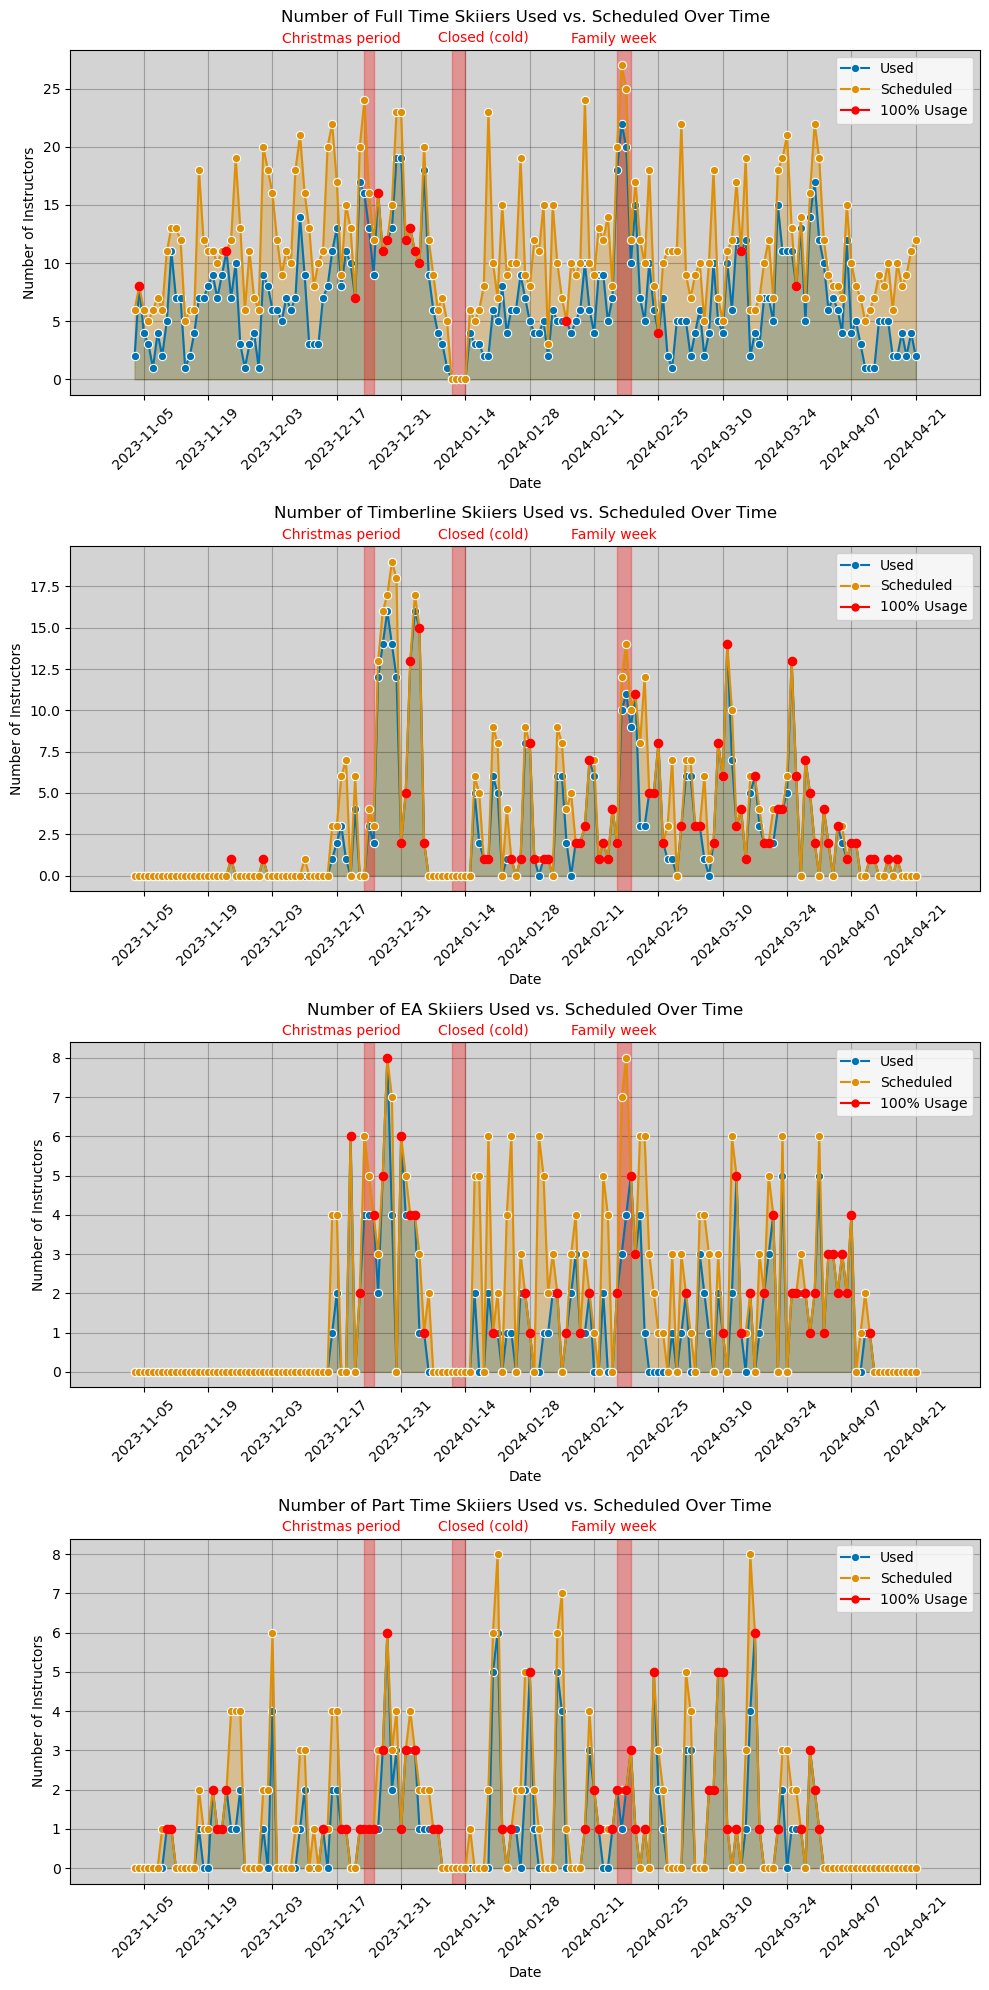

In [55]:
# Select ski utilization rate columns
df_retail.rename(columns={
    'num_active_FT_ski':'Number of Full Time Skiiers Used',
    'num_active_TBL_ski':'Number of Timberline Skiiers Used',
    'num_active_EA_ski':'Number of EA Skiiers Used',
    'num_active_PT_ski':'Number of Part Time Skiiers Used',
    'num_retail_available_ins_FT_ski':'Number of Full Time Skiiers Scheduled',
    'num_retail_available_ins_TBL_ski':'Number of Timberline Skiiers Scheduled',
    'num_retail_available_ins_EA_ski':'Number of EA Skiiers Scheduled',
    'num_retail_available_ins_PT_ski':'Number of Part Time Skiiers Scheduled'},
                inplace=True)
util_nums_ski = [col for col in df_retail.columns if (col.startswith('Number') & col.endswith('Skiiers Used'))]
util_avails_ski = [col for col in df_retail.columns if (col.startswith('Number') & col.endswith('Skiiers Scheduled'))]

# Iterate through indices and set util_avails_ski equal to util_nums_ski if the latter is greater
for index in df_retail.index:
    for col_num, col_avail in zip(util_nums_ski, util_avails_ski):
        if df_retail.loc[index, col_num] > df_retail.loc[index, col_avail]:
            df_retail.loc[index, col_avail] = df_retail.loc[index, col_num]

# Create subplots
num_plots = len(util_nums_ski)
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots), sharex=False)

# Define a color palette
palette = sns.color_palette("colorblind", 2)

# Plot each column in a separate subplot
for ax, col_num, col_avail in zip(axes, util_nums_ski, util_avails_ski):

    # Line plot for Number of Instructors Used
    sns.lineplot(x=df_retail.index, y=df_retail[col_num], ax=ax, marker='o', color=palette[0], label='Used')
    ax.fill_between(df_retail.index, df_retail[col_num], alpha=0.3, color=palette[0])

    # Line plot for Number of Instructors Scheduled
    sns.lineplot(x=df_retail.index, y=df_retail[col_avail], ax=ax, marker='o', color=palette[1], label='Scheduled')
    ax.fill_between(df_retail.index, df_retail[col_avail], alpha=0.3, color=palette[1])

    # Highlight plot points in red when the two values are the same and not zero
    same_values_indices = df_retail[(df_retail[col_num] == df_retail[col_avail]) & (df_retail[col_num] != 0)].index
    for index in same_values_indices:
        ax.scatter(index, df_retail.loc[index, col_num], color='red', zorder=5)  # Highlight with red color

    # Set title
    ax.set_title(f'{col_num} vs. Scheduled Over Time', pad=20)
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Instructors')

    # Set x-axis limits
    ax.set_xlim(df_retail.index[0] + pd.Timedelta(days=-14), df_retail.index[-1] + pd.Timedelta(days=14))

    # Customize the grid to have a new vertical grid line every 2 weeks
    start_date = df_retail.index[0]
    date_range = pd.date_range(start=start_date + pd.Timedelta(days=2), end=df_retail.index[-1], freq='2W')
    ax.set_xticks(date_range)

    # Draw darker horizontal grid lines manually
    ax.yaxis.grid(True, linestyle='-', color='k', alpha=0.25)
    ax.xaxis.grid(True, linestyle='-', color='k', alpha=0.25)

    # Add a vertical bar for Christmas period
    ax.axvspan(pd.Timestamp('2023-12-23'), pd.Timestamp('2023-12-25'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2023-12-23') - pd.Timedelta(days=18), ax.get_ylim()[1]+(5.5*ax.get_ylim()[1]/100), 'Christmas period', color='red', rotation=0, va='top')

    # Add a vertical bar for cold closure
    ax.axvspan(pd.Timestamp('2024-01-11'), pd.Timestamp('2024-01-14'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-01-11') - pd.Timedelta(days=3), ax.get_ylim()[1]+(5.7*ax.get_ylim()[1]/100), 'Closed (cold)', color='red', rotation=0, va='top')

    # Add a vertical bar for Family week
    ax.axvspan(pd.Timestamp('2024-02-16'), pd.Timestamp('2024-02-19'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-02-16')- pd.Timedelta(days=10), ax.get_ylim()[1]+(5.5*ax.get_ylim()[1]/100), 'Family week', color='red', rotation=0, va='top')

    # Customize the x-ticks for each subplot
    ax.tick_params(axis='x', rotation=45)

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    if '100% Usage' not in labels:  # Ensure 'Fully booked' label is not duplicated
        handles.append(plt.Line2D([], [], color='red', marker='o', markersize=5, label='100% Usage'))
    ax.legend(handles=handles, loc='upper right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

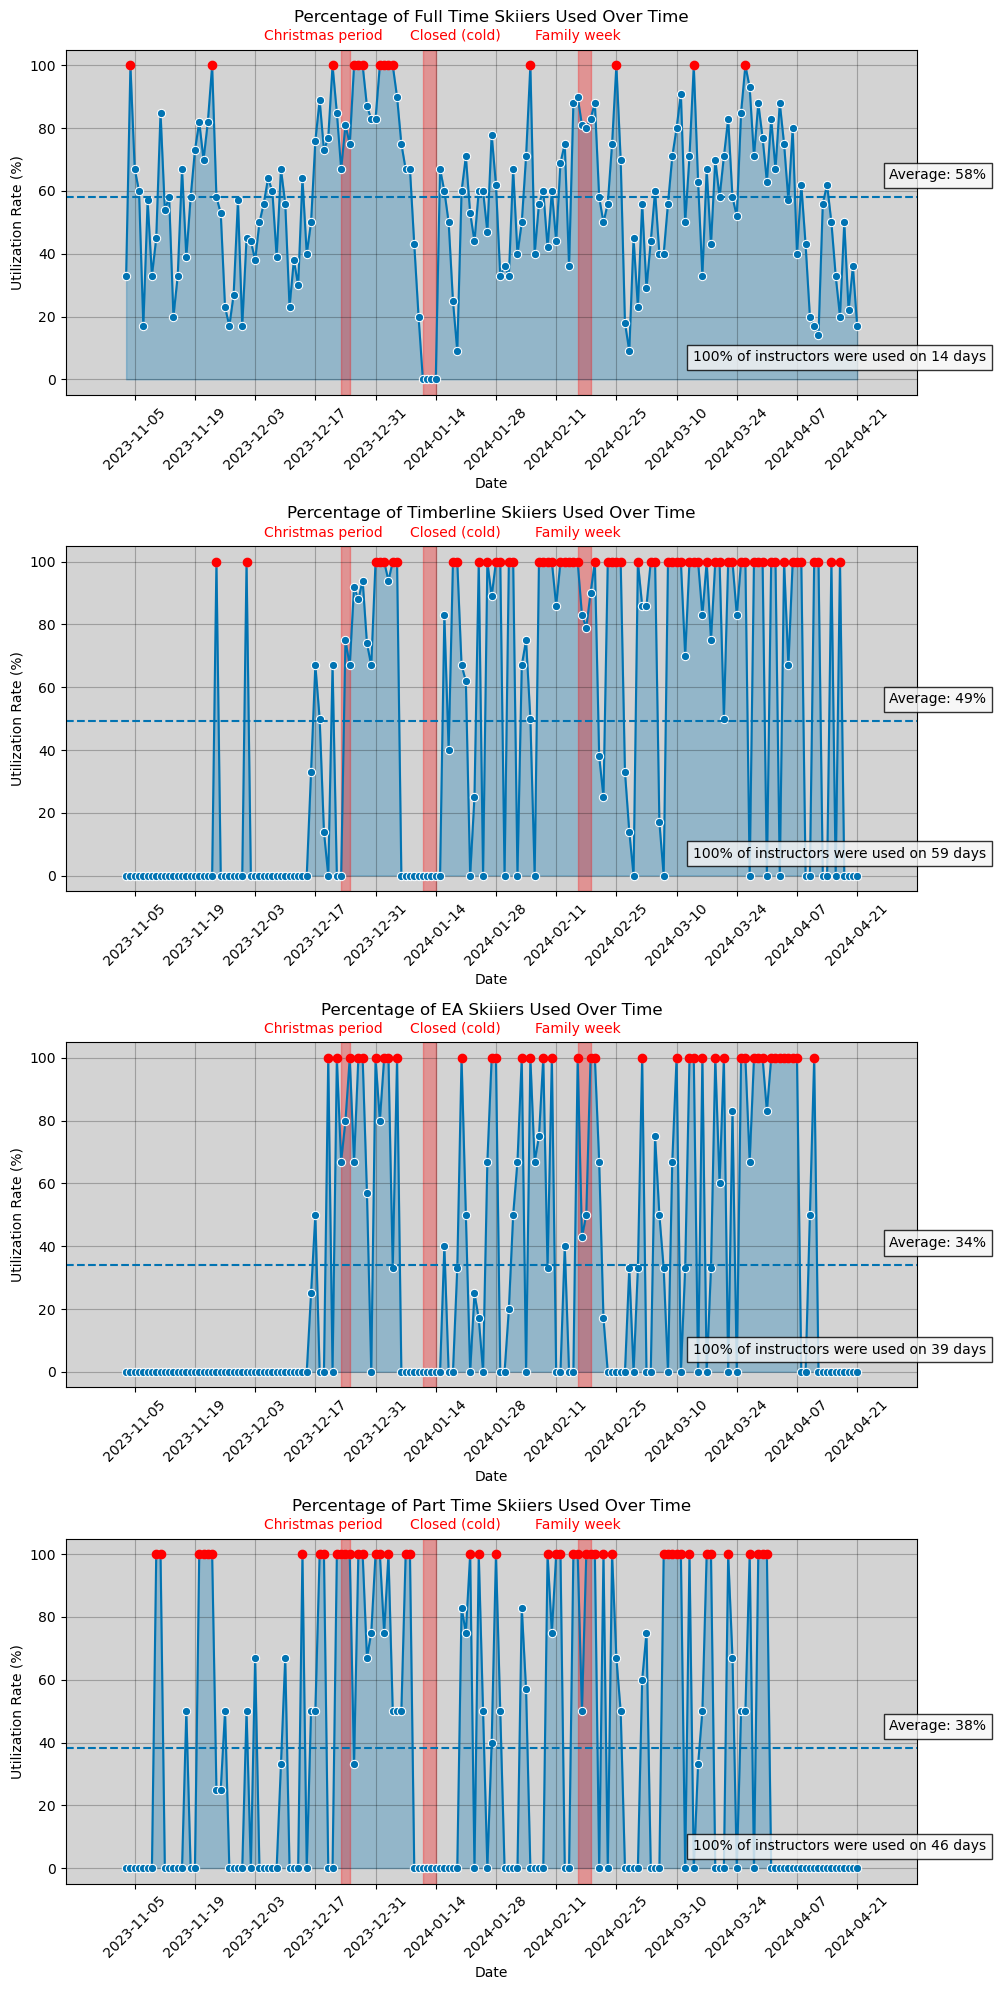

In [56]:
# Select ski utilization rate columns
df_retail.rename(columns={
    'util_rate_FT_ski':'Percentage of Full Time Skiiers Used',
    'util_rate_TBL_ski':'Percentage of Timberline Skiiers Used',
    'util_rate_EA_ski':'Percentage of EA Skiiers Used',
    'util_rate_PT_ski':'Percentage of Part Time Skiiers Used'},
                inplace=True)
util_rate_ski = [col for col in df_retail.columns if (col.startswith('Percentage') & col.endswith('Skiiers Used'))]

# Create subplots
num_plots = len(util_rate_ski)
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots), sharex=False)

# Define a color palette
palette = sns.color_palette("colorblind", num_plots)
plot_color = palette[0]

# Plot each column in a separate subplot
#for ax, col, color in zip(axes, util_rate_ski, palette):
for ax, col in zip(axes, util_rate_ski):

    sns.lineplot(x=df_retail.index, y=df_retail[col], ax=ax, marker='o', color=plot_color)
    ax.fill_between(df_retail.index, df_retail[col], alpha=0.3, color=plot_color)
    #ax.set_title(f'{col} Over Time')
    ax.set_title(f'{col} Over Time', pad=20)
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('Date')
    ax.set_ylabel('Utilization Rate (%)')

    # Highlight points where value is 100
    highlight = df_retail[df_retail[col] == 100]
    ax.scatter(highlight.index, highlight[col], color='red', zorder=5)  # Highlight with red color
    
    # Set x-axis limits
    ax.set_xlim(df_retail.index[0] + pd.Timedelta(days=-14), df_retail.index[-1] + pd.Timedelta(days=14))

    # Customize the grid to have a new vertical grid line every 2 weeks
    start_date = df_retail.index[0]
    date_range = pd.date_range(start=start_date + pd.Timedelta(days=2), end=df_retail.index[-1], freq='2W')
    ax.set_xticks(date_range)

    # Draw darker horizontal grid lines manually
    ax.yaxis.grid(True, linestyle='-', color='k', alpha=0.25)
    ax.xaxis.grid(True, linestyle='-', color='k', alpha=0.25)

    # Add a labeled horizontal line showing the average value
    average_value = df_retail[col].mean()
    ax.axhline(y=average_value, linestyle='--', color=plot_color)
    ax.text(df_retail.index[-1] + pd.Timedelta(days=30), average_value+7, 'Average: {}%'.format(round(average_value)), va='center', ha='right', bbox=dict(facecolor='#F5F5F5', alpha=0.8))
    
    # Add a vertical bar for Christmas period
    ax.axvspan(pd.Timestamp('2023-12-23'), pd.Timestamp('2023-12-25'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2023-12-23') - pd.Timedelta(days=18), ax.get_ylim()[1]+6.5, 'Christmas period', color='red', rotation=0, va='top')

    # Add a vertical bar for cold closure
    ax.axvspan(pd.Timestamp('2024-01-11'), pd.Timestamp('2024-01-14'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-01-11') - pd.Timedelta(days=3), ax.get_ylim()[1]+6.7, 'Closed (cold)', color='red', rotation=0, va='top')

    # Add a vertical bar for Family week
    ax.axvspan(pd.Timestamp('2024-02-16'), pd.Timestamp('2024-02-19'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-02-16')- pd.Timedelta(days=10), ax.get_ylim()[1]+6.5, 'Family week', color='red', rotation=0, va='top')

    # Customize the x-ticks for each subplot
    ax.tick_params(axis='x', rotation=45)

    # Display number of full-usage days
    print_text = '100% of instructors were used on {} days'.format(np.sum(df_retail.loc[:,col] == 100))
    ax.text(df_retail.index[-1] + pd.Timedelta(days=30), ax.get_ylim()[0]+12, print_text, va='center', ha='right', bbox=dict(facecolor='#F5F5F5', alpha=0.8))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Plot snowboard instructor usage variables

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

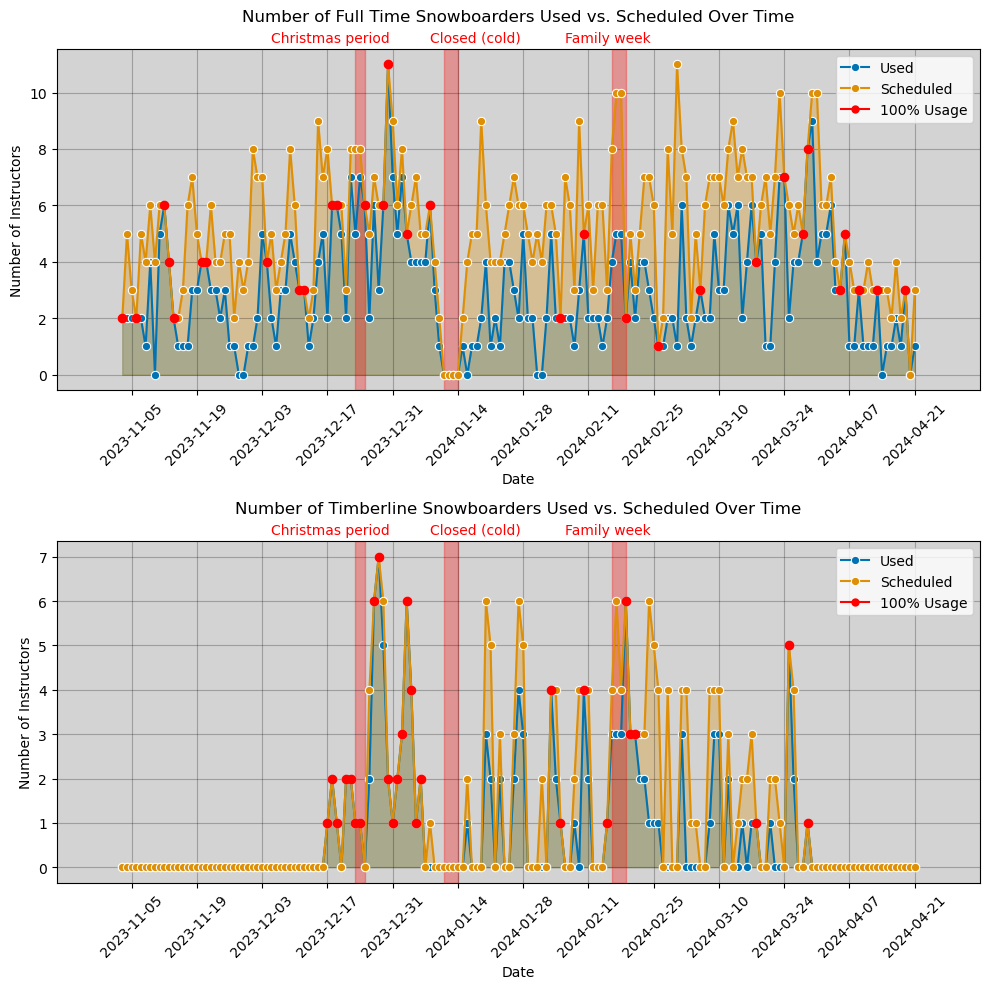

In [58]:
# Select ski utilization rate columns
df_retail.rename(columns={
    'num_active_FT_sbd':'Number of Full Time Snowboarders Used',
    'num_active_TBL_sbd':'Number of Timberline Snowboarders Used',
    'num_retail_available_ins_FT_sbd':'Number of Full Time Snowboarders Scheduled',
    'num_retail_available_ins_TBL_sbd':'Number of Timberline Snowboarders Scheduled'},
                inplace=True)
util_nums_sbd = [col for col in df_retail.columns if (col.startswith('Number') & col.endswith('Snowboarders Used'))]
util_avails_sbd = [col for col in df_retail.columns if (col.startswith('Number') & col.endswith('Snowboarders Scheduled'))]

# Iterate through indices and set util_avails_ski equal to util_nums_ski if the latter is greater
for index in df_retail.index:
    for col_num, col_avail in zip(util_nums_sbd, util_avails_sbd):
        if df_retail.loc[index, col_num] > df_retail.loc[index, col_avail]:
            df_retail.loc[index, col_avail] = df_retail.loc[index, col_num]

# Create subplots
num_plots = len(util_nums_sbd)
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots), sharex=False)

# Define a color palette
palette = sns.color_palette("colorblind", 2)

# Plot each column in a separate subplot
for ax, col_num, col_avail in zip(axes, util_nums_sbd, util_avails_sbd):

    # Line plot for Number of Instructors Used
    sns.lineplot(x=df_retail.index, y=df_retail[col_num], ax=ax, marker='o', color=palette[0], label='Used')
    ax.fill_between(df_retail.index, df_retail[col_num], alpha=0.3, color=palette[0])

    # Line plot for Number of Instructors Scheduled
    sns.lineplot(x=df_retail.index, y=df_retail[col_avail], ax=ax, marker='o', color=palette[1], label='Scheduled')
    ax.fill_between(df_retail.index, df_retail[col_avail], alpha=0.3, color=palette[1])

    # Highlight plot points in red when the two values are the same and not zero
    same_values_indices = df_retail[(df_retail[col_num] == df_retail[col_avail]) & (df_retail[col_num] != 0)].index
    for index in same_values_indices:
        ax.scatter(index, df_retail.loc[index, col_num], color='red', zorder=5)  # Highlight with red color

    # Set title
    ax.set_title(f'{col_num} vs. Scheduled Over Time', pad=20)
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Instructors')

    # Set x-axis limits
    ax.set_xlim(df_retail.index[0] + pd.Timedelta(days=-14), df_retail.index[-1] + pd.Timedelta(days=14))

    # Customize the grid to have a new vertical grid line every 2 weeks
    start_date = df_retail.index[0]
    date_range = pd.date_range(start=start_date + pd.Timedelta(days=2), end=df_retail.index[-1], freq='2W')
    ax.set_xticks(date_range)

    # Draw darker horizontal grid lines manually
    ax.yaxis.grid(True, linestyle='-', color='k', alpha=0.25)
    ax.xaxis.grid(True, linestyle='-', color='k', alpha=0.25)

    # Add a vertical bar for Christmas period
    ax.axvspan(pd.Timestamp('2023-12-23'), pd.Timestamp('2023-12-25'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2023-12-23') - pd.Timedelta(days=18), ax.get_ylim()[1]+(5.5*ax.get_ylim()[1]/100), 'Christmas period', color='red', rotation=0, va='top')

    # Add a vertical bar for cold closure
    ax.axvspan(pd.Timestamp('2024-01-11'), pd.Timestamp('2024-01-14'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-01-11') - pd.Timedelta(days=3), ax.get_ylim()[1]+(5.7*ax.get_ylim()[1]/100), 'Closed (cold)', color='red', rotation=0, va='top')

    # Add a vertical bar for Family week
    ax.axvspan(pd.Timestamp('2024-02-16'), pd.Timestamp('2024-02-19'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-02-16')- pd.Timedelta(days=10), ax.get_ylim()[1]+(5.5*ax.get_ylim()[1]/100), 'Family week', color='red', rotation=0, va='top')

    # Customize the x-ticks for each subplot
    ax.tick_params(axis='x', rotation=45)

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    if '100% Usage' not in labels:  # Ensure 'Fully booked' label is not duplicated
        handles.append(plt.Line2D([], [], color='red', marker='o', markersize=5, label='100% Usage'))
    ax.legend(handles=handles, loc='upper right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

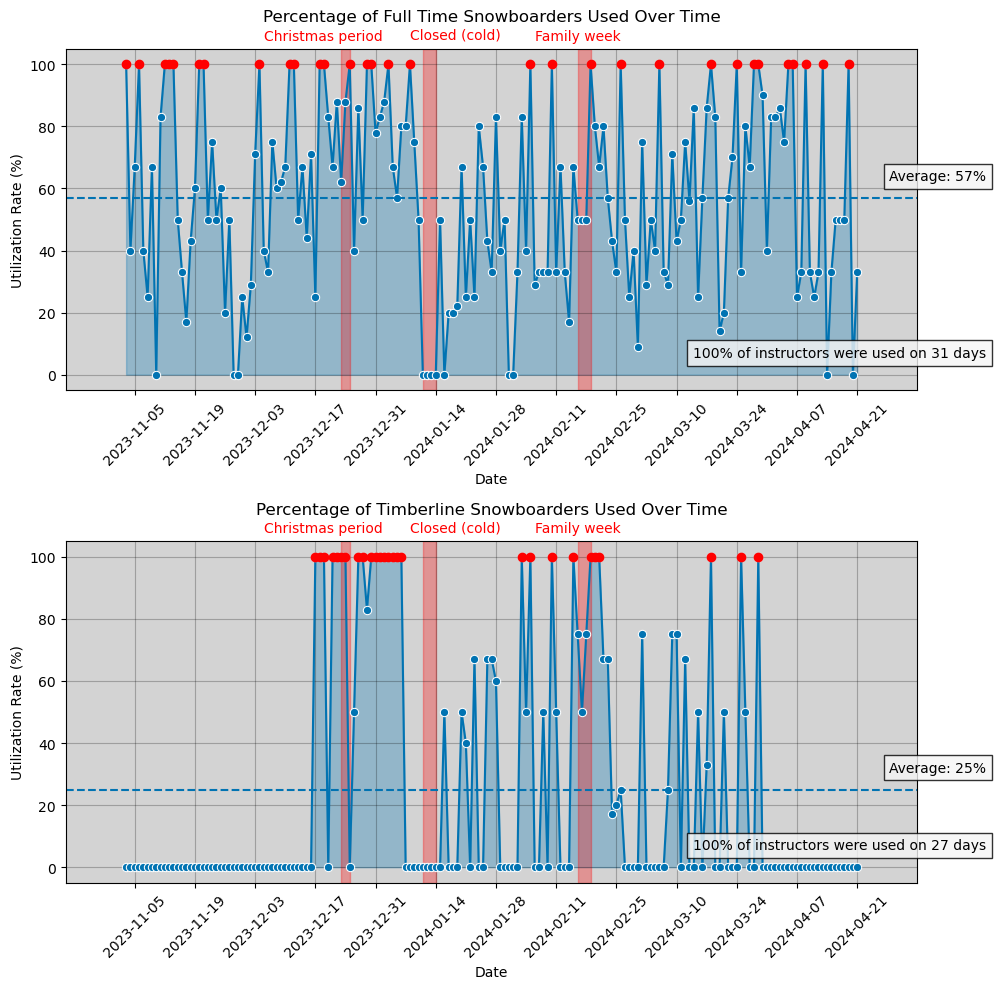

In [59]:
# Select snowboard utilization rate columns
df_retail.rename(columns={
    'util_rate_FT_sbd':'Percentage of Full Time Snowboarders Used',
    'util_rate_TBL_sbd':'Percentage of Timberline Snowboarders Used'},
                inplace=True)
util_rate_sbd = [col for col in df_retail.columns if col.startswith('Percentage') & col.endswith('Snowboarders Used')]

# Create subplots
num_plots = len(util_rate_sbd)
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots), sharex=False)

# Define a color palette
palette = sns.color_palette("colorblind", num_plots)
plot_color = palette[0]

# Plot each column in a separate subplot
#for ax, col, color in zip(axes, util_rate_ski, palette):
for ax, col in zip(axes, util_rate_sbd):

    sns.lineplot(x=df_retail.index, y=df_retail[col], ax=ax, marker='o', color=plot_color)
    ax.fill_between(df_retail.index, df_retail[col], alpha=0.3, color=plot_color)
    #ax.set_title(f'{col} Over Time')
    ax.set_title(f'{col} Over Time', pad=20)
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('Date')
    ax.set_ylabel('Utilization Rate (%)')

    # Highlight points where value is 100
    highlight = df_retail[df_retail[col] == 100]
    ax.scatter(highlight.index, highlight[col], color='red', zorder=5)  # Highlight with red color
    
    # Set x-axis limits
    ax.set_xlim(df_retail.index[0] + pd.Timedelta(days=-14), df_retail.index[-1] + pd.Timedelta(days=14))

    # Customize the grid to have a new vertical grid line every 2 weeks
    start_date = df_retail.index[0]
    date_range = pd.date_range(start=start_date + pd.Timedelta(days=2), end=df_retail.index[-1], freq='2W')
    ax.set_xticks(date_range)

    # Draw darker horizontal grid lines manually
    ax.yaxis.grid(True, linestyle='-', color='k', alpha=0.25)
    ax.xaxis.grid(True, linestyle='-', color='k', alpha=0.25)

    # Add a labeled horizontal line showing the average value
    average_value = df_retail[col].mean()
    ax.axhline(y=average_value, linestyle='--', color=plot_color)
    ax.text(df_retail.index[-1] + pd.Timedelta(days=30), average_value+7, 'Average: {}%'.format(round(average_value)), va='center', ha='right', bbox=dict(facecolor='#F5F5F5', alpha=0.8))
    
    # Add a vertical bar for Christmas period
    ax.axvspan(pd.Timestamp('2023-12-23'), pd.Timestamp('2023-12-25'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2023-12-23') - pd.Timedelta(days=18), ax.get_ylim()[1]+6.5, 'Christmas period', color='red', rotation=0, va='top')

    # Add a vertical bar for cold closure
    ax.axvspan(pd.Timestamp('2024-01-11'), pd.Timestamp('2024-01-14'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-01-11') - pd.Timedelta(days=3), ax.get_ylim()[1]+6.7, 'Closed (cold)', color='red', rotation=0, va='top')

    # Add a vertical bar for Family week
    ax.axvspan(pd.Timestamp('2024-02-16'), pd.Timestamp('2024-02-19'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-02-16')- pd.Timedelta(days=10), ax.get_ylim()[1]+6.5, 'Family week', color='red', rotation=0, va='top')

    # Customize the x-ticks for each subplot
    ax.tick_params(axis='x', rotation=45)

    # Display number of full-usage days
    print_text = '100% of instructors were used on {} days'.format(np.sum(df_retail.loc[:,col] == 100))
    ax.text(df_retail.index[-1] + pd.Timedelta(days=30), ax.get_ylim()[0]+12, print_text, va='center', ha='right', bbox=dict(facecolor='#F5F5F5', alpha=0.8))


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Generate plots pertaining to how often retail is sold out

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

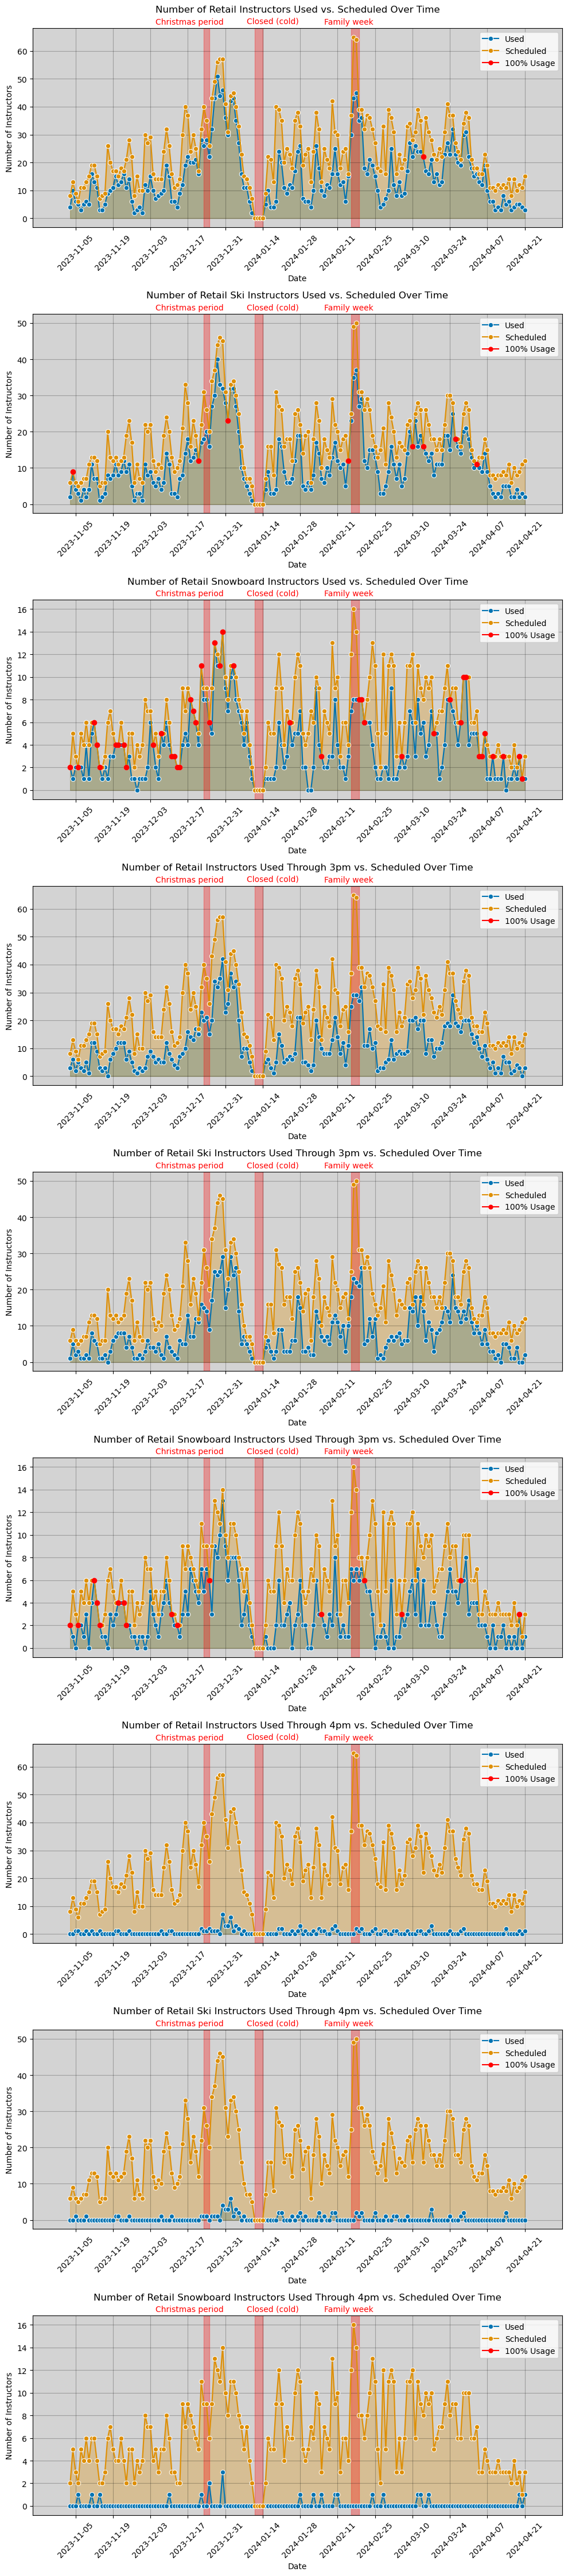

In [61]:
# Select ski utilization rate columns
df_retail.rename(columns={
    'retail_active_instructors':'Number of Retail Instructors Used',
    'total_active_ski_instructors':'Number of Retail Ski Instructors Used',
    'total_active_sbd_instructors':'Number of Retail Snowboard Instructors Used',
    'num_ins_3pm':'Number of Retail Instructors Used Through 3pm',
    'num_ins_3pm_ski':'Number of Retail Ski Instructors Used Through 3pm',
    'num_ins_3pm_sbd':'Number of Retail Snowboard Instructors Used Through 3pm',
    'num_ins_4pm':'Number of Retail Instructors Used Through 4pm',
    'num_ins_4pm_ski':'Number of Retail Ski Instructors Used Through 4pm',
    'num_ins_4pm_sbd':'Number of Retail Snowboard Instructors Used Through 4pm',
    'num_retail_available_ins':'Number of Instructors Scheduled',
    'num_retail_available_ins_ski':'Number of Ski Instructors Scheduled',
    'num_retail_available_ins_sbd':'Number of Snowboard Instructors Scheduled'},
                inplace=True)
util_nums = [col for col in df_retail.columns if (col.startswith('Number') & ('Instructors Used' in col))]
util_avails = [col for col in df_retail.columns if (col.startswith('Number') & ('Instructors Scheduled' in col))]*3

# Iterate through indices and set util_avails equal to util_nums if the latter is greater
for index in df_retail.index:
    for col_num, col_avail in zip(util_nums, util_avails):
        if df_retail.loc[index, col_num] > df_retail.loc[index, col_avail]:
            df_retail.loc[index, col_avail] = df_retail.loc[index, col_num]

# Create subplots
num_plots = len(util_nums)
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots), sharex=False)

# Define a color palette
palette = sns.color_palette("colorblind", 2)

# Plot each column in a separate subplot
for ax, col_num, col_avail in zip(axes, util_nums, util_avails):

    # Line plot for Number of Instructors Used
    sns.lineplot(x=df_retail.index, y=df_retail[col_num], ax=ax, marker='o', color=palette[0], label='Used')
    ax.fill_between(df_retail.index, df_retail[col_num], alpha=0.3, color=palette[0])

    # Line plot for Number of Instructors Scheduled
    sns.lineplot(x=df_retail.index, y=df_retail[col_avail], ax=ax, marker='o', color=palette[1], label='Scheduled')
    ax.fill_between(df_retail.index, df_retail[col_avail], alpha=0.3, color=palette[1])

    # Highlight plot points in red when the two values are the same and not zero
    same_values_indices = df_retail[(df_retail[col_num] == df_retail[col_avail]) & (df_retail[col_num] != 0)].index
    for index in same_values_indices:
        ax.scatter(index, df_retail.loc[index, col_num], color='red', zorder=5)  # Highlight with red color

    # Set title
    ax.set_title(f'{col_num} vs. Scheduled Over Time', pad=20)
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Instructors')

    # Set x-axis limits
    ax.set_xlim(df_retail.index[0] + pd.Timedelta(days=-14), df_retail.index[-1] + pd.Timedelta(days=14))

    # Customize the grid to have a new vertical grid line every 2 weeks
    start_date = df_retail.index[0]
    date_range = pd.date_range(start=start_date + pd.Timedelta(days=2), end=df_retail.index[-1], freq='2W')
    ax.set_xticks(date_range)

    # Draw darker horizontal grid lines manually
    ax.yaxis.grid(True, linestyle='-', color='k', alpha=0.25)
    ax.xaxis.grid(True, linestyle='-', color='k', alpha=0.25)

    # Add a vertical bar for Christmas period
    ax.axvspan(pd.Timestamp('2023-12-23'), pd.Timestamp('2023-12-25'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2023-12-23') - pd.Timedelta(days=18), ax.get_ylim()[1]+(5.5*ax.get_ylim()[1]/100), 'Christmas period', color='red', rotation=0, va='top')

    # Add a vertical bar for cold closure
    ax.axvspan(pd.Timestamp('2024-01-11'), pd.Timestamp('2024-01-14'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-01-11') - pd.Timedelta(days=3), ax.get_ylim()[1]+(5.7*ax.get_ylim()[1]/100), 'Closed (cold)', color='red', rotation=0, va='top')

    # Add a vertical bar for Family week
    ax.axvspan(pd.Timestamp('2024-02-16'), pd.Timestamp('2024-02-19'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-02-16')- pd.Timedelta(days=10), ax.get_ylim()[1]+(5.5*ax.get_ylim()[1]/100), 'Family week', color='red', rotation=0, va='top')

    # Customize the x-ticks for each subplot
    ax.tick_params(axis='x', rotation=45)

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    if '100% Usage' not in labels:  # Ensure 'Fully booked' label is not duplicated
        handles.append(plt.Line2D([], [], color='red', marker='o', markersize=5, label='100% Usage'))
    ax.legend(handles=handles, loc='upper right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

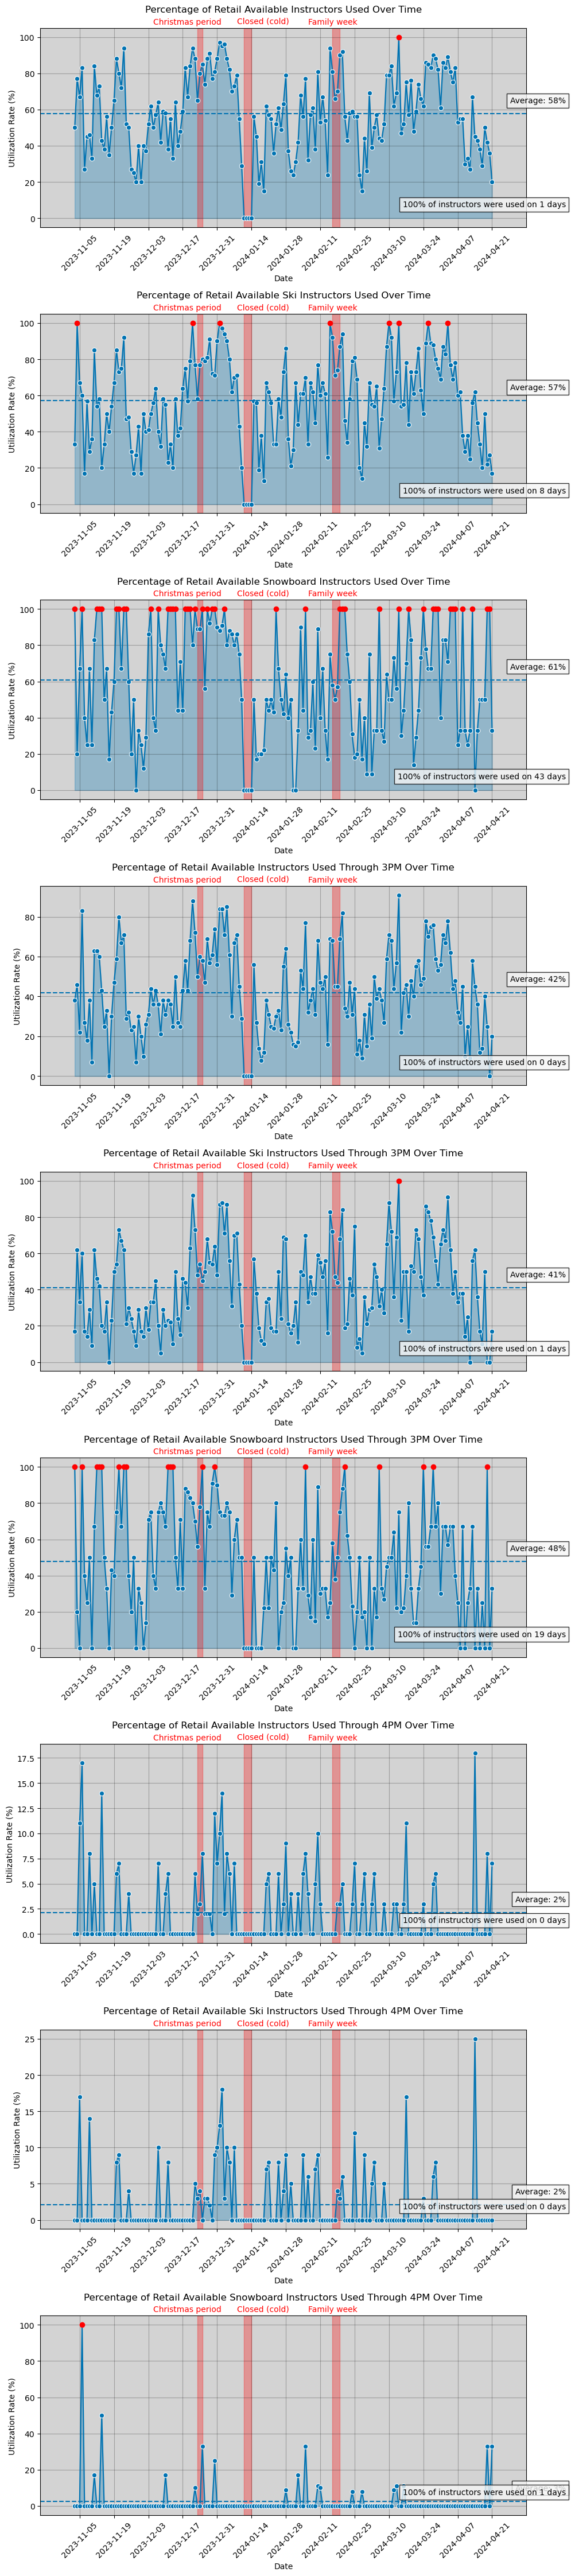

In [62]:
# Select sold out variables
df_retail.rename(columns={
    'pct_sold_out':'Percentage of Retail Available Instructors Used',
    'pct_sold_out_ski':'Percentage of Retail Available Ski Instructors Used',
    'pct_sold_out_sbd':'Percentage of Retail Available Snowboard Instructors Used',
    'pct_sold_out_3pm':'Percentage of Retail Available Instructors Used Through 3PM',
    'pct_sold_out_3pm_ski':'Percentage of Retail Available Ski Instructors Used Through 3PM',
    'pct_sold_out_3pm_sbd':'Percentage of Retail Available Snowboard Instructors Used Through 3PM',
    'pct_sold_out_4pm':'Percentage of Retail Available Instructors Used Through 4PM',
    'pct_sold_out_4pm_ski':'Percentage of Retail Available Ski Instructors Used Through 4PM',
    'pct_sold_out_4pm_sbd':'Percentage of Retail Available Snowboard Instructors Used Through 4PM'},
                inplace=True)
util_rate_all = [col for col in df_retail.columns if col.startswith('Percentage of Retail')]

# Create subplots
num_plots = len(util_rate_all)
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots), sharex=False)

# Define a color palette
palette = sns.color_palette("colorblind", num_plots)
plot_color = palette[0]

# Plot each column in a separate subplot
#for ax, col, color in zip(axes, util_rate_ski, palette):
for ax, col in zip(axes, util_rate_all):

    sns.lineplot(x=df_retail.index, y=df_retail[col], ax=ax, marker='o', color=plot_color)
    ax.fill_between(df_retail.index, df_retail[col], alpha=0.3, color=plot_color)
    #ax.set_title(f'{col} Over Time')
    ax.set_title(f'{col} Over Time', pad=20)
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('Date')
    ax.set_ylabel('Utilization Rate (%)')

    # Highlight points where value is 100
    highlight = df_retail[df_retail[col] == 100]
    ax.scatter(highlight.index, highlight[col], color='red', zorder=5)  # Highlight with red color
    
    # Set x-axis limits
    ax.set_xlim(df_retail.index[0] + pd.Timedelta(days=-14), df_retail.index[-1] + pd.Timedelta(days=14))

    # Customize the grid to have a new vertical grid line every 2 weeks
    start_date = df_retail.index[0]
    date_range = pd.date_range(start=start_date + pd.Timedelta(days=2), end=df_retail.index[-1], freq='2W')
    ax.set_xticks(date_range)

    # Draw darker horizontal grid lines manually
    ax.yaxis.grid(True, linestyle='-', color='k', alpha=0.25)
    ax.xaxis.grid(True, linestyle='-', color='k', alpha=0.25)

    # Add a labeled horizontal line showing the average value
    average_value = df_retail[col].mean()
    ax.axhline(y=average_value, linestyle='--', color=plot_color)
    ax.text(df_retail.index[-1] + pd.Timedelta(days=30), average_value+(7*ax.get_ylim()[1]/100), 'Average: {}%'.format(round(average_value)), va='center', ha='right', bbox=dict(facecolor='#F5F5F5', alpha=0.8))
    
    # Add a vertical bar for Christmas period
    ax.axvspan(pd.Timestamp('2023-12-23'), pd.Timestamp('2023-12-25'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2023-12-23') - pd.Timedelta(days=18), ax.get_ylim()[1]+(5.5*ax.get_ylim()[1]/100), 'Christmas period', color='red', rotation=0, va='top')

    # Add a vertical bar for cold closure
    ax.axvspan(pd.Timestamp('2024-01-11'), pd.Timestamp('2024-01-14'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-01-11') - pd.Timedelta(days=3), ax.get_ylim()[1]+(5.7*ax.get_ylim()[1]/100), 'Closed (cold)', color='red', rotation=0, va='top')

    # Add a vertical bar for Family week
    ax.axvspan(pd.Timestamp('2024-02-16'), pd.Timestamp('2024-02-19'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-02-16')- pd.Timedelta(days=10), ax.get_ylim()[1]+(5.5*ax.get_ylim()[1]/100), 'Family week', color='red', rotation=0, va='top')

    # Customize the x-ticks for each subplot
    ax.tick_params(axis='x', rotation=45)

    # Display number of full-usage days
    print_text = '100% of instructors were used on {} days'.format(np.sum(df_retail.loc[:,col] == 100))
    ax.text(df_retail.index[-1] + pd.Timedelta(days=30), ax.get_ylim()[0] + (12*ax.get_ylim()[1]/100), print_text, va='center', ha='right', bbox=dict(facecolor='#F5F5F5', alpha=0.8))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Generate plots pertaining to how often retail is sold out for each day of the week

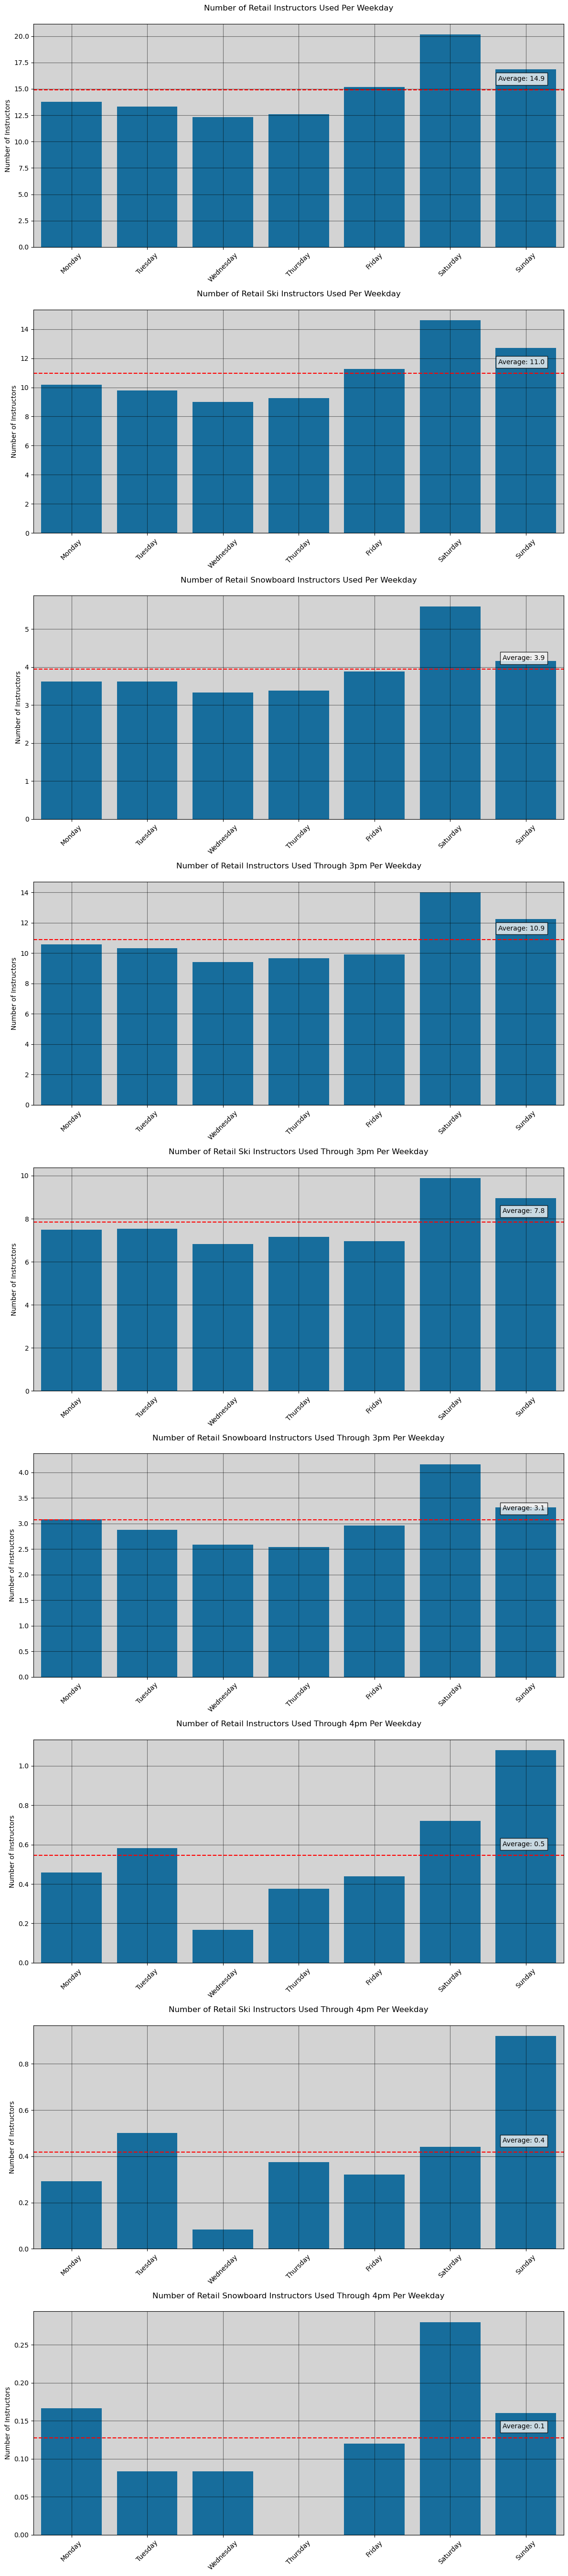

In [78]:
# Aggregate data by day_of_week
df_aggregated = df_retail.groupby('day_of_week')[util_nums].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Create subplots
num_plots = len(util_nums)
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 6 * num_plots), sharex=False)

# Define a color palette
palette = sns.color_palette("colorblind")

# Get the first color from the palette
first_color = palette[0]

# Plot each column in a separate subplot
for ax, col in zip(axes, util_nums):
    sns.barplot(x=df_aggregated.index, y=df_aggregated[col], ax=ax, color=first_color)  # Use first_color for all subplots
    ax.set_title(f'{col} Per Weekday', pad=20)  # Adjust title position by setting pad
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('')
    ax.set_ylabel('Number of Instructors')
    
    # Customize the grid
    ax.yaxis.grid(True, linestyle='-', color='k', alpha=0.5)
    ax.xaxis.grid(True, linestyle='-', color='k', alpha=0.5)

    # Add a labeled horizontal line showing the average value
    average_value = df_aggregated[col].mean()
    ax.axhline(y=average_value, linestyle='--', color='red')
    ax.text(len(df_aggregated.index) - 0.75, average_value+(5*ax.get_ylim()[1]/100),'Average: {}'.format(round(average_value, 1)), va='center', ha='right', bbox=dict(facecolor='#F5F5F5', alpha=0.8))
    #ax.text(df_retail.index[-1] + pd.Timedelta(days=30), average_value+(7*ax.get_ylim()[1]/100), 'Average: {}%'.format(round(average_value)), va='center', ha='right', bbox=dict(facecolor='#F5F5F5', alpha=0.8))

    # Customize the x-ticks for each subplot
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

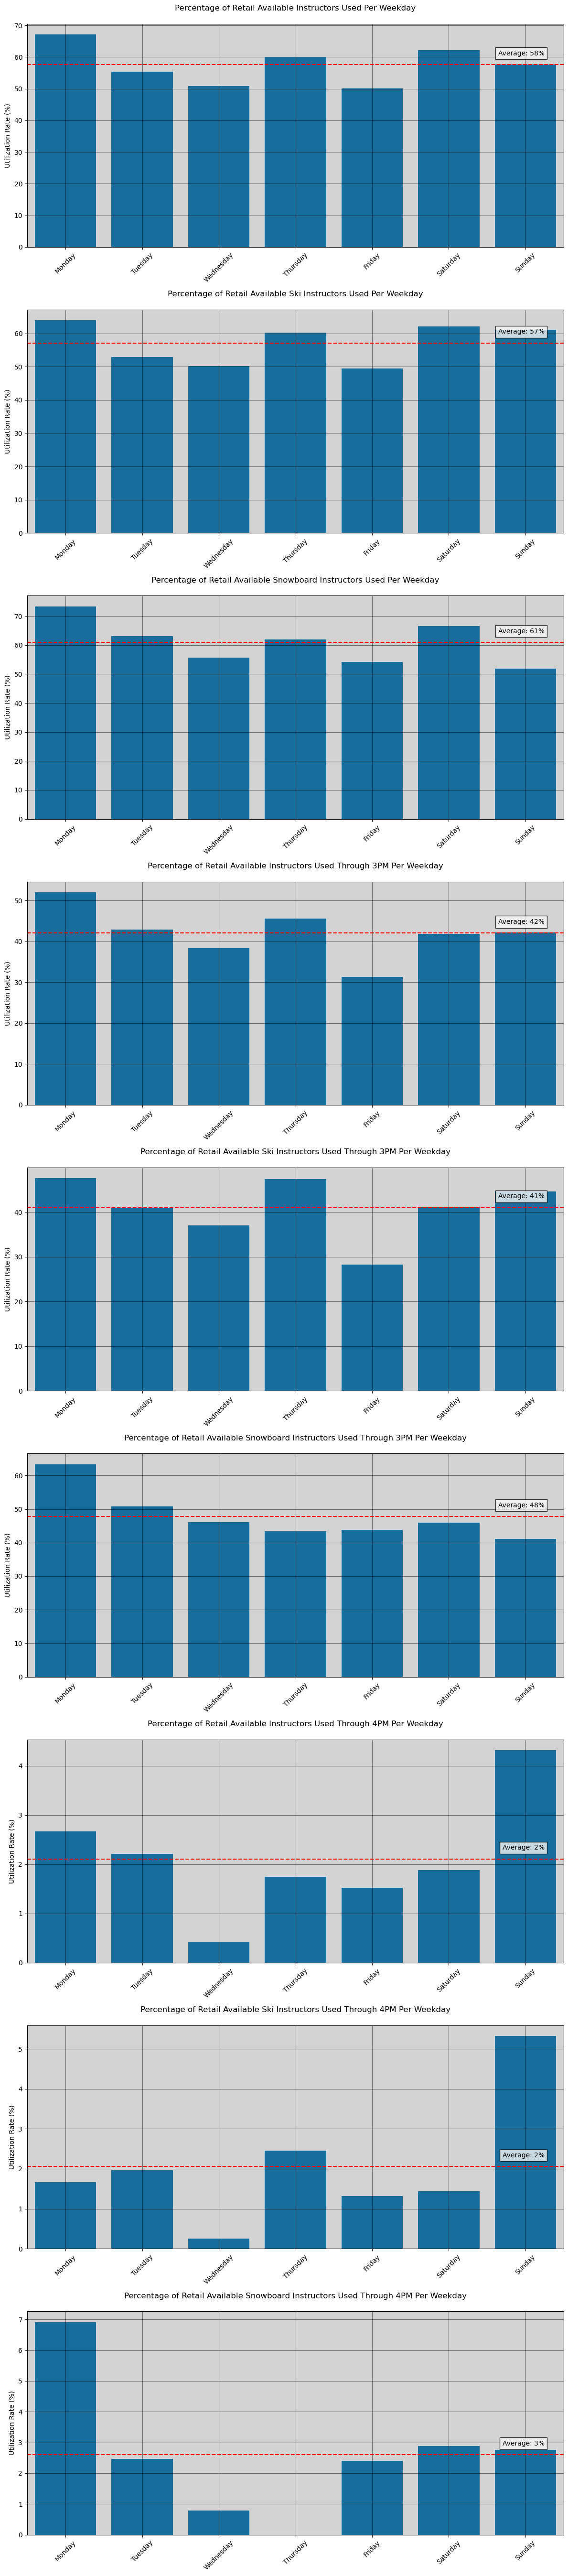

In [72]:
# Aggregate data by day_of_week
df_aggregated = df_retail.groupby('day_of_week')[util_rate_all].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Create subplots
num_plots = len(util_rate_all)
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 6 * num_plots), sharex=False)

# Define a color palette
palette = sns.color_palette("colorblind")

# Get the first color from the palette
first_color = palette[0]

# Plot each column in a separate subplot
for ax, col in zip(axes, util_rate_all):
    sns.barplot(x=df_aggregated.index, y=df_aggregated[col], ax=ax, color=first_color)  # Use first_color for all subplots
    ax.set_title(f'{col} Per Weekday', pad=20)  # Adjust title position by setting pad
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('')
    ax.set_ylabel('Utilization Rate (%)')
    
    # Customize the grid
    ax.yaxis.grid(True, linestyle='-', color='k', alpha=0.5)
    ax.xaxis.grid(True, linestyle='-', color='k', alpha=0.5)

    # Add a labeled horizontal line showing the average value
    average_value = df_aggregated[col].mean()
    ax.axhline(y=average_value, linestyle='--', color='red')
    ax.text(len(df_aggregated.index) - 0.75, average_value+(5*ax.get_ylim()[1]/100),'Average: {}%'.format(round(average_value)), va='center', ha='right', bbox=dict(facecolor='#F5F5F5', alpha=0.8))
    #ax.text(df_retail.index[-1] + pd.Timedelta(days=30), average_value+(7*ax.get_ylim()[1]/100), 'Average: {}%'.format(round(average_value)), va='center', ha='right', bbox=dict(facecolor='#F5F5F5', alpha=0.8))

    # Customize the x-ticks for each subplot
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Generate plots showing general booking trends

In [66]:
# Format df_retail_lessons
df_retail_lessons.set_index('Date', inplace=True)
df_retail_lessons['day_of_week'] = df_retail_lessons.index.get_level_values(0).day_name()

/tmp/ipykernel_2309/220386902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retail_lessons['day_of_week'] = df_retail_lessons.index.get_level_values(0).day_name()


In [67]:
# Rename pertinent variables as necessary
df_retail_lessons.rename(columns={
    'lesson_type':'Lesson Type',
    'customer_type':'Customer Age Group',
    'lesson_length':'Lesson Length (Hours)'},
                inplace=True)
lesson_variables = ['Level', 'Lesson Type', 'Customer Age Group', 'Lesson Length (Hours)']

/tmp/ipykernel_2309/1226328267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retail_lessons.rename(columns={


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

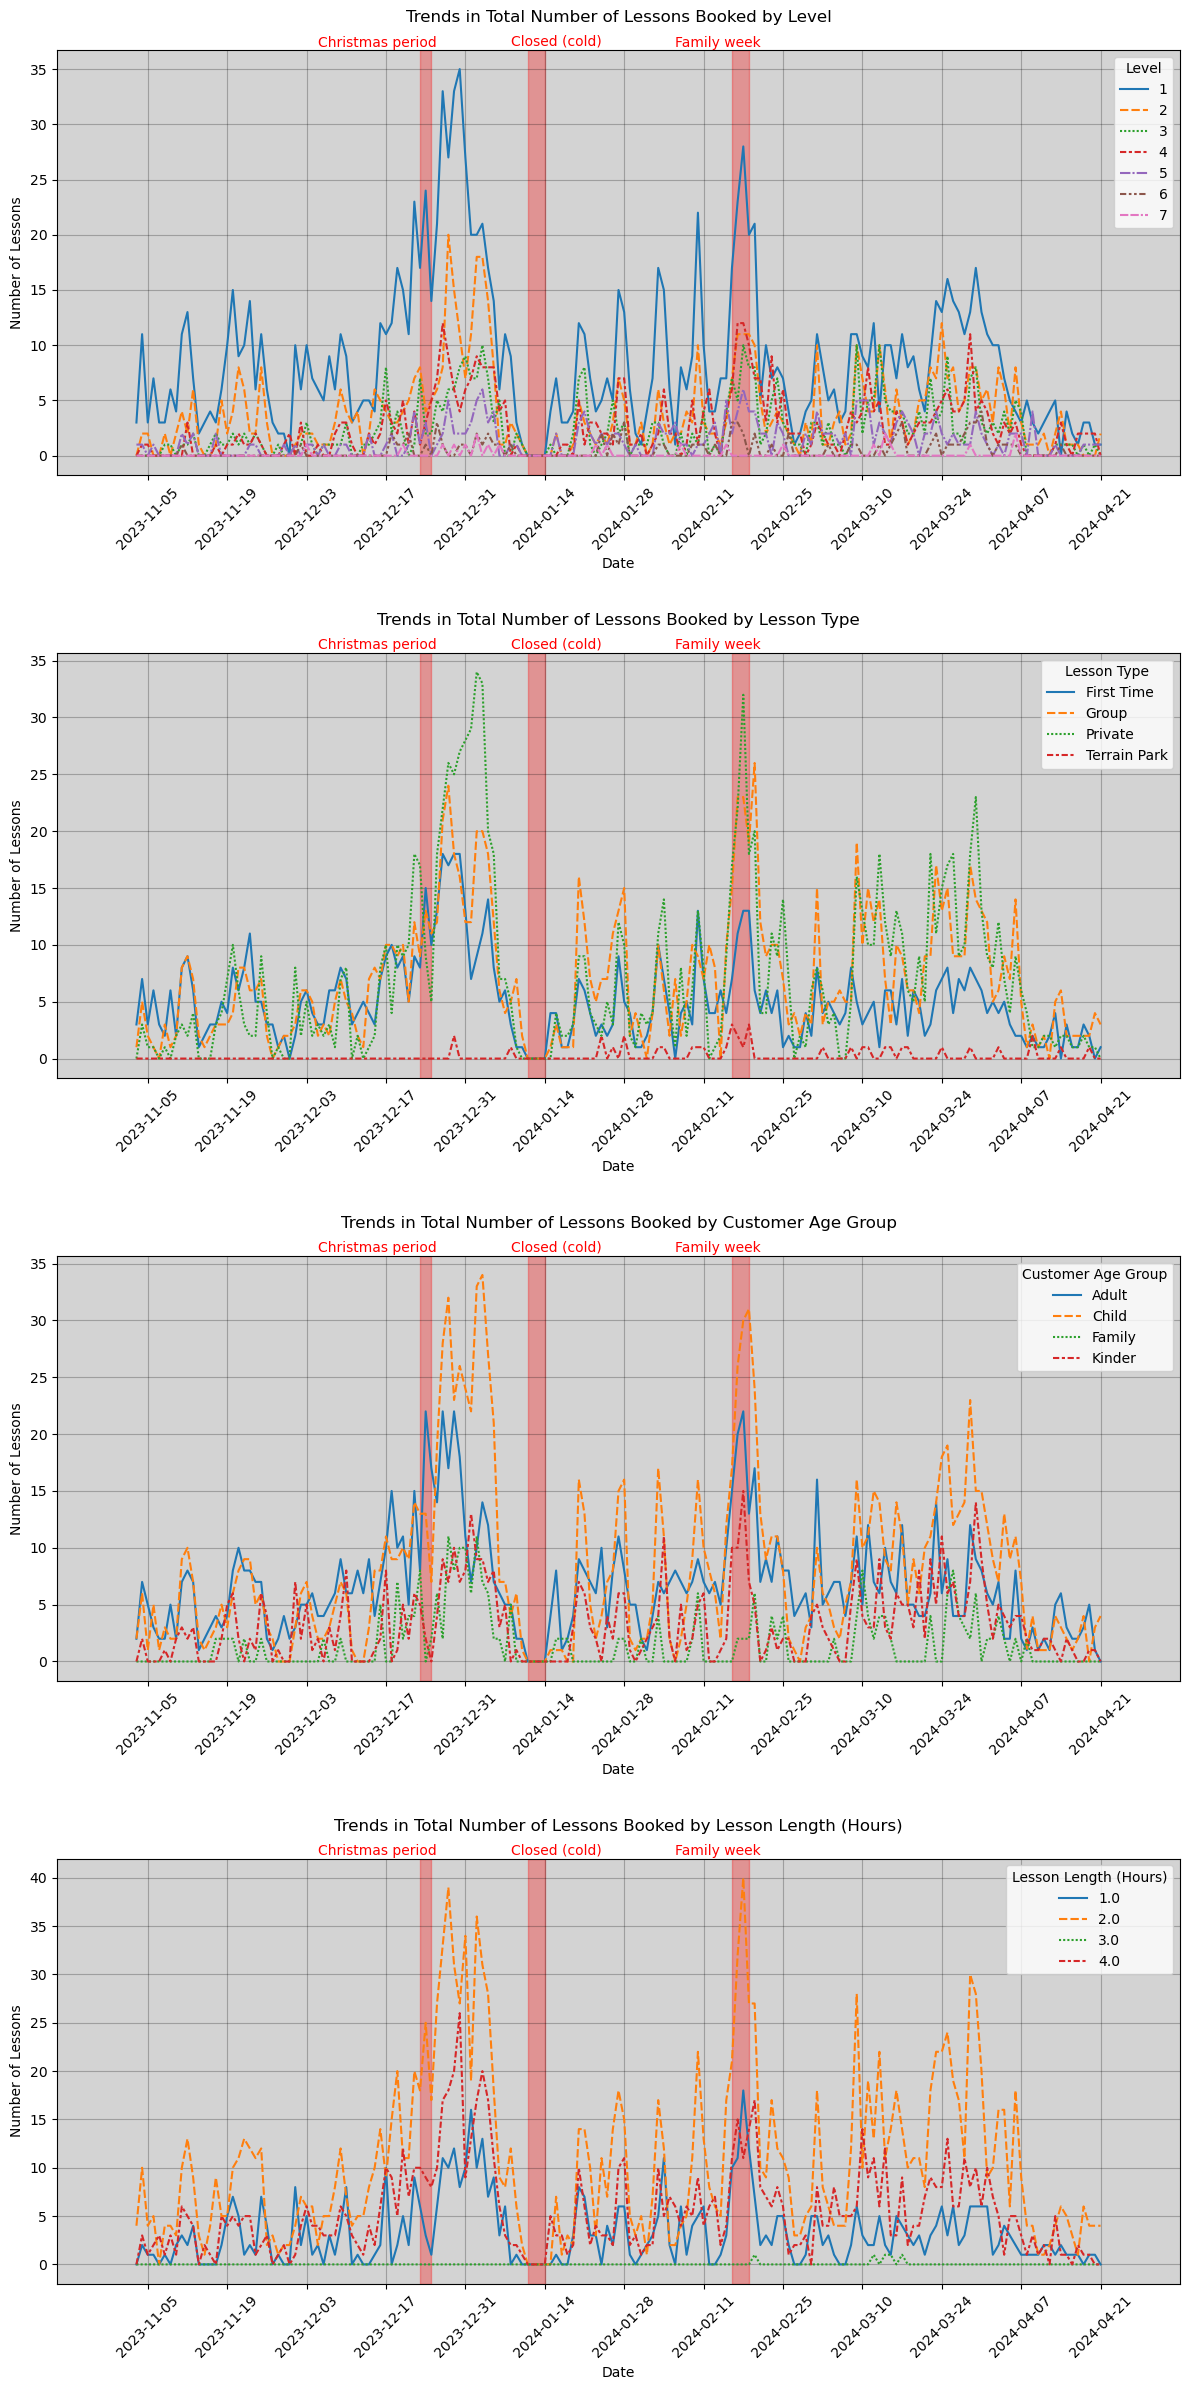

In [82]:
# Create subplots without sharing x-axis
fig, axes = plt.subplots(len(lesson_variables), 1, figsize=(12, 6 * len(lesson_variables)), sharex=False)

# Plot each variable
for ax, variable in zip(axes, lesson_variables):
    # Group by 'Date' and the variable, then count the number of lessons
    grouped = df_retail_lessons.groupby([df_retail_lessons.index, variable]).size().unstack().fillna(0)

    # Reindex to fill missing dates with 0s
    full_date_range = pd.date_range(start=df_retail_lessons.index.min(), end=df_retail_lessons.index.max(), freq='D')
    grouped = grouped.reindex(full_date_range, fill_value=0)

    # Plot the data
    sns.lineplot(data=grouped, ax=ax)
    ax.set_title(f'Trends in Total Number of Lessons Booked by {variable}', pad=20)
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Lessons')
    ax.legend(title=variable)

    # Set x-axis limits
    ax.set_xlim(df_retail_lessons.index[0] + pd.Timedelta(days=-14), df_retail_lessons.index[-1] + pd.Timedelta(days=14))

    # Draw darker horizontal grid lines manually
    ax.yaxis.grid(True, linestyle='-', color='k', alpha=0.25)
    ax.xaxis.grid(True, linestyle='-', color='k', alpha=0.25)

    # Add a vertical bar for Christmas period
    ax.axvspan(pd.Timestamp('2023-12-23'), pd.Timestamp('2023-12-25'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2023-12-23') - pd.Timedelta(days=18), ax.get_ylim()[1] + (3.5 * ax.get_ylim()[1] / 100), 'Christmas period', color='red', rotation=0, va='top')

    # Add a vertical bar for cold closure
    ax.axvspan(pd.Timestamp('2024-01-11'), pd.Timestamp('2024-01-14'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-01-11') - pd.Timedelta(days=3), ax.get_ylim()[1] + (3.7 * ax.get_ylim()[1] / 100), 'Closed (cold)', color='red', rotation=0, va='top')

    # Add a vertical bar for Family week
    ax.axvspan(pd.Timestamp('2024-02-16'), pd.Timestamp('2024-02-19'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-02-16') - pd.Timedelta(days=10), ax.get_ylim()[1] + (3.5 * ax.get_ylim()[1] / 100), 'Family week', color='red', rotation=0, va='top')

    # Customize the x-ticks for each subplot
    ax.tick_params(axis='x', rotation=45)
    # Set x-ticks for each subplot
    date_range = pd.date_range(start=df_retail_lessons.index.min(), end=df_retail_lessons.index.max(), freq='2W')
    ax.set_xticks(date_range)

# Adjust layout with more spacing between subplots
plt.tight_layout(h_pad=3)

# Show the plot
plt.show()

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

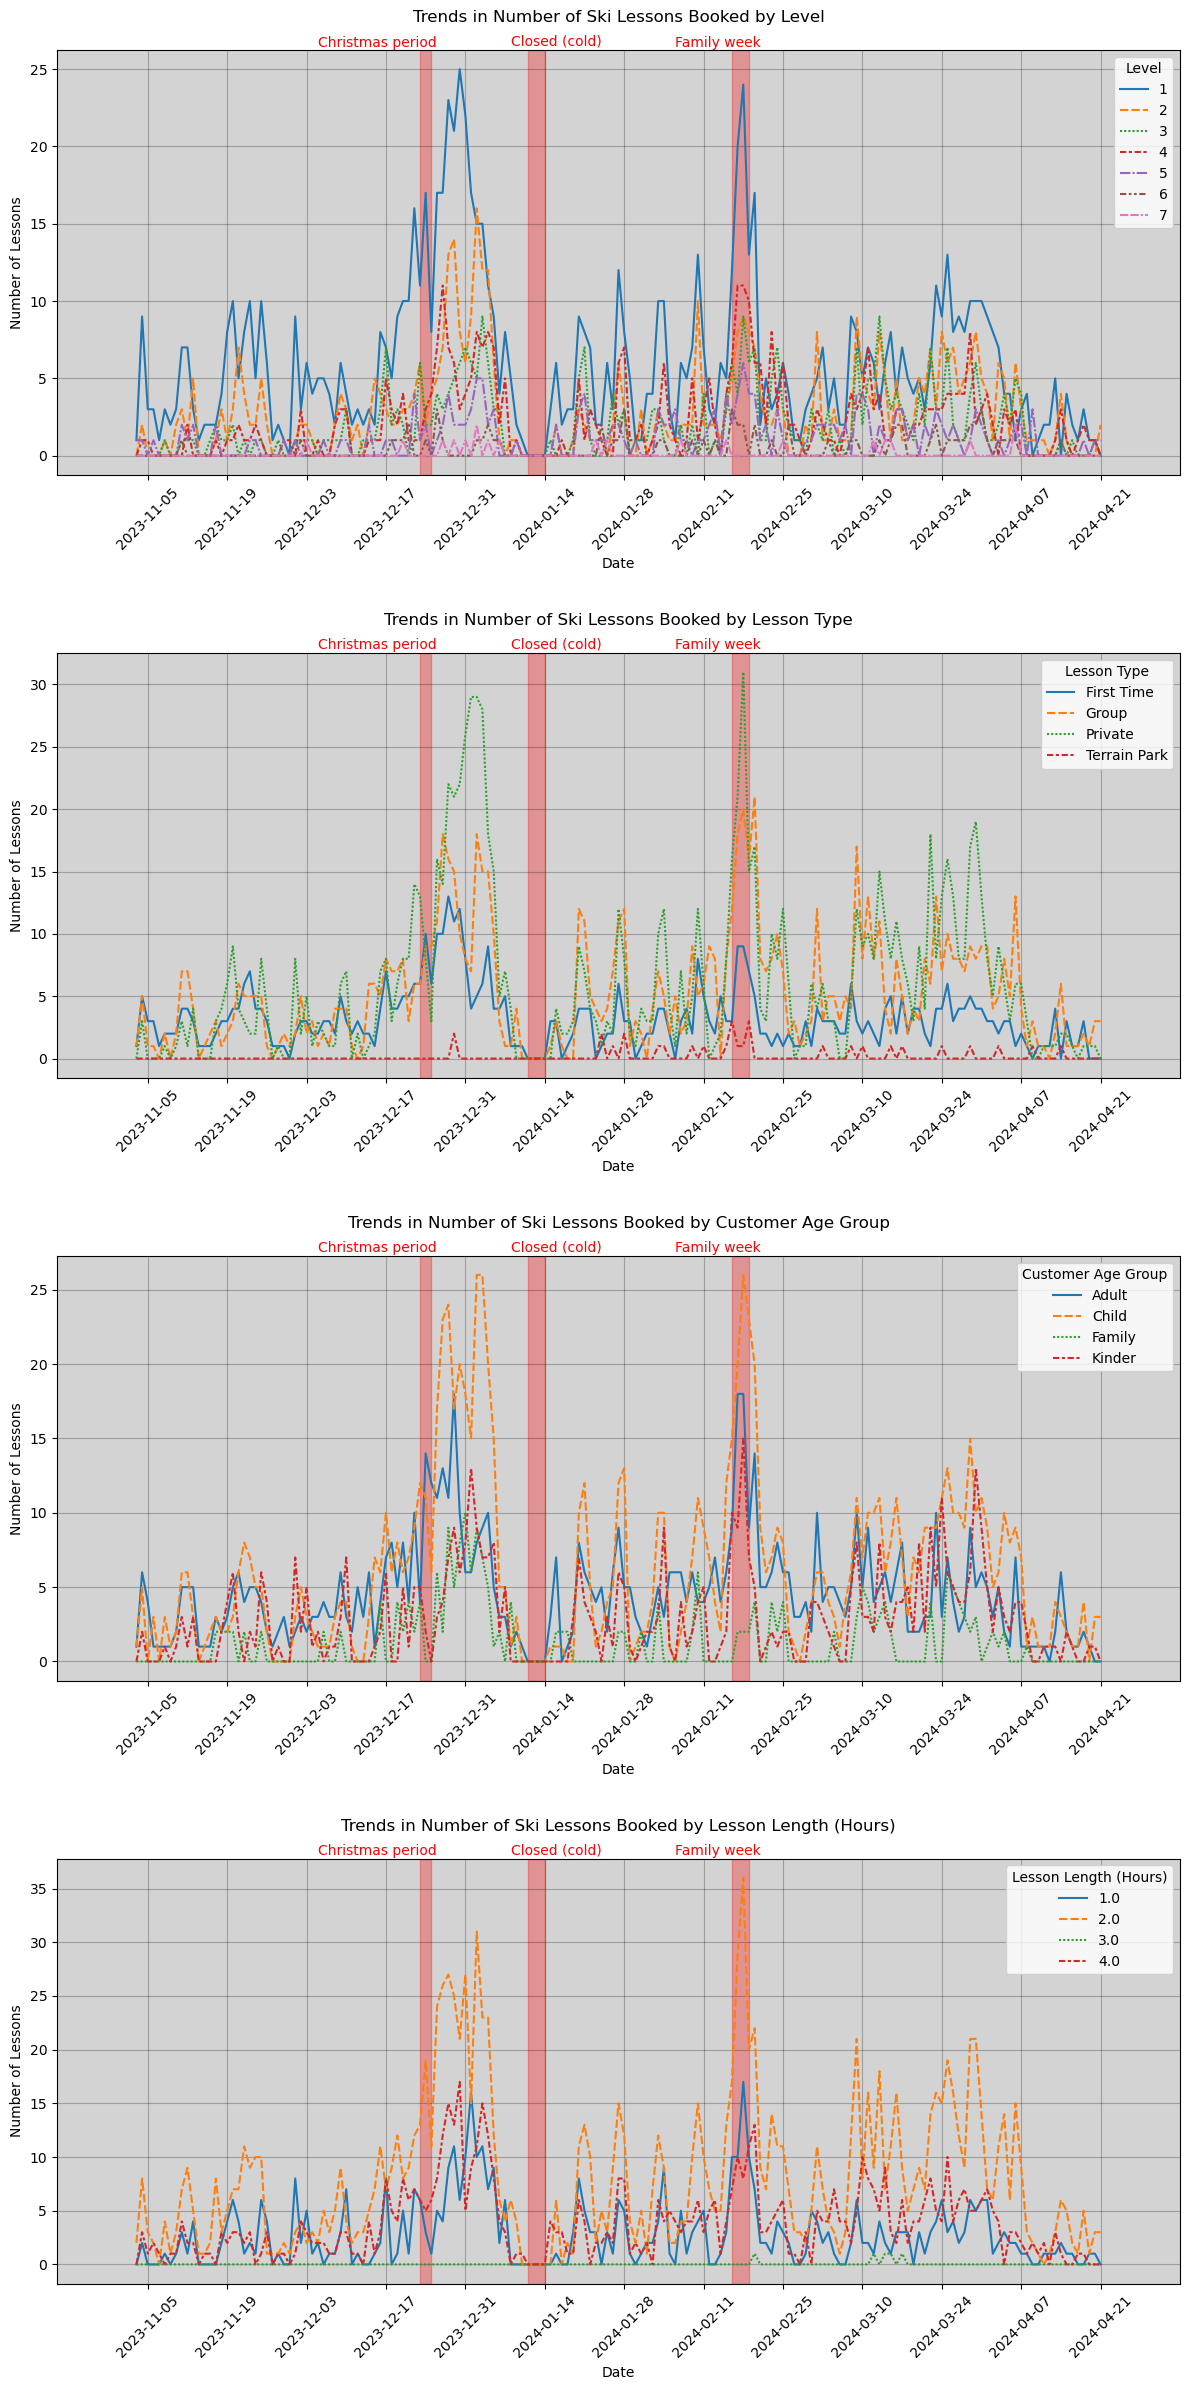

In [68]:
# Filter to just Ski lessons
df_retail_lessons_ski = df_retail_lessons.loc[df_retail_lessons.loc[:,'Activity'] == 'Ski', :]

# Create subplots without sharing x-axis
fig, axes = plt.subplots(len(lesson_variables), 1, figsize=(12, 6 * len(lesson_variables)), sharex=False)

# Plot each variable
for ax, variable in zip(axes, lesson_variables):
    # Group by 'Date' and the variable, then count the number of lessons
    grouped = df_retail_lessons_ski.groupby([df_retail_lessons_ski.index, variable]).size().unstack().fillna(0)

    # Reindex to fill missing dates with 0s
    full_date_range = pd.date_range(start=df_retail_lessons_ski.index.min(), end=df_retail_lessons_ski.index.max(), freq='D')
    grouped = grouped.reindex(full_date_range, fill_value=0)

    # Plot the data
    sns.lineplot(data=grouped, ax=ax)
    ax.set_title(f'Trends in Number of Ski Lessons Booked by {variable}', pad=20)
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Lessons')
    ax.legend(title=variable)

    # Set x-axis limits
    ax.set_xlim(df_retail_lessons_ski.index[0] + pd.Timedelta(days=-14), df_retail_lessons_ski.index[-1] + pd.Timedelta(days=14))

    # Draw darker horizontal grid lines manually
    ax.yaxis.grid(True, linestyle='-', color='k', alpha=0.25)
    ax.xaxis.grid(True, linestyle='-', color='k', alpha=0.25)

    # Add a vertical bar for Christmas period
    ax.axvspan(pd.Timestamp('2023-12-23'), pd.Timestamp('2023-12-25'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2023-12-23') - pd.Timedelta(days=18), ax.get_ylim()[1] + (3.5 * ax.get_ylim()[1] / 100), 'Christmas period', color='red', rotation=0, va='top')

    # Add a vertical bar for cold closure
    ax.axvspan(pd.Timestamp('2024-01-11'), pd.Timestamp('2024-01-14'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-01-11') - pd.Timedelta(days=3), ax.get_ylim()[1] + (3.7 * ax.get_ylim()[1] / 100), 'Closed (cold)', color='red', rotation=0, va='top')

    # Add a vertical bar for Family week
    ax.axvspan(pd.Timestamp('2024-02-16'), pd.Timestamp('2024-02-19'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-02-16') - pd.Timedelta(days=10), ax.get_ylim()[1] + (3.5 * ax.get_ylim()[1] / 100), 'Family week', color='red', rotation=0, va='top')

    # Customize the x-ticks for each subplot
    ax.tick_params(axis='x', rotation=45)
    # Set x-ticks for each subplot
    date_range = pd.date_range(start=df_retail_lessons_ski.index.min(), end=df_retail_lessons_ski.index.max(), freq='2W')
    ax.set_xticks(date_range)

# Adjust layout with more spacing between subplots
plt.tight_layout(h_pad=3)

# Show the plot
plt.show()

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

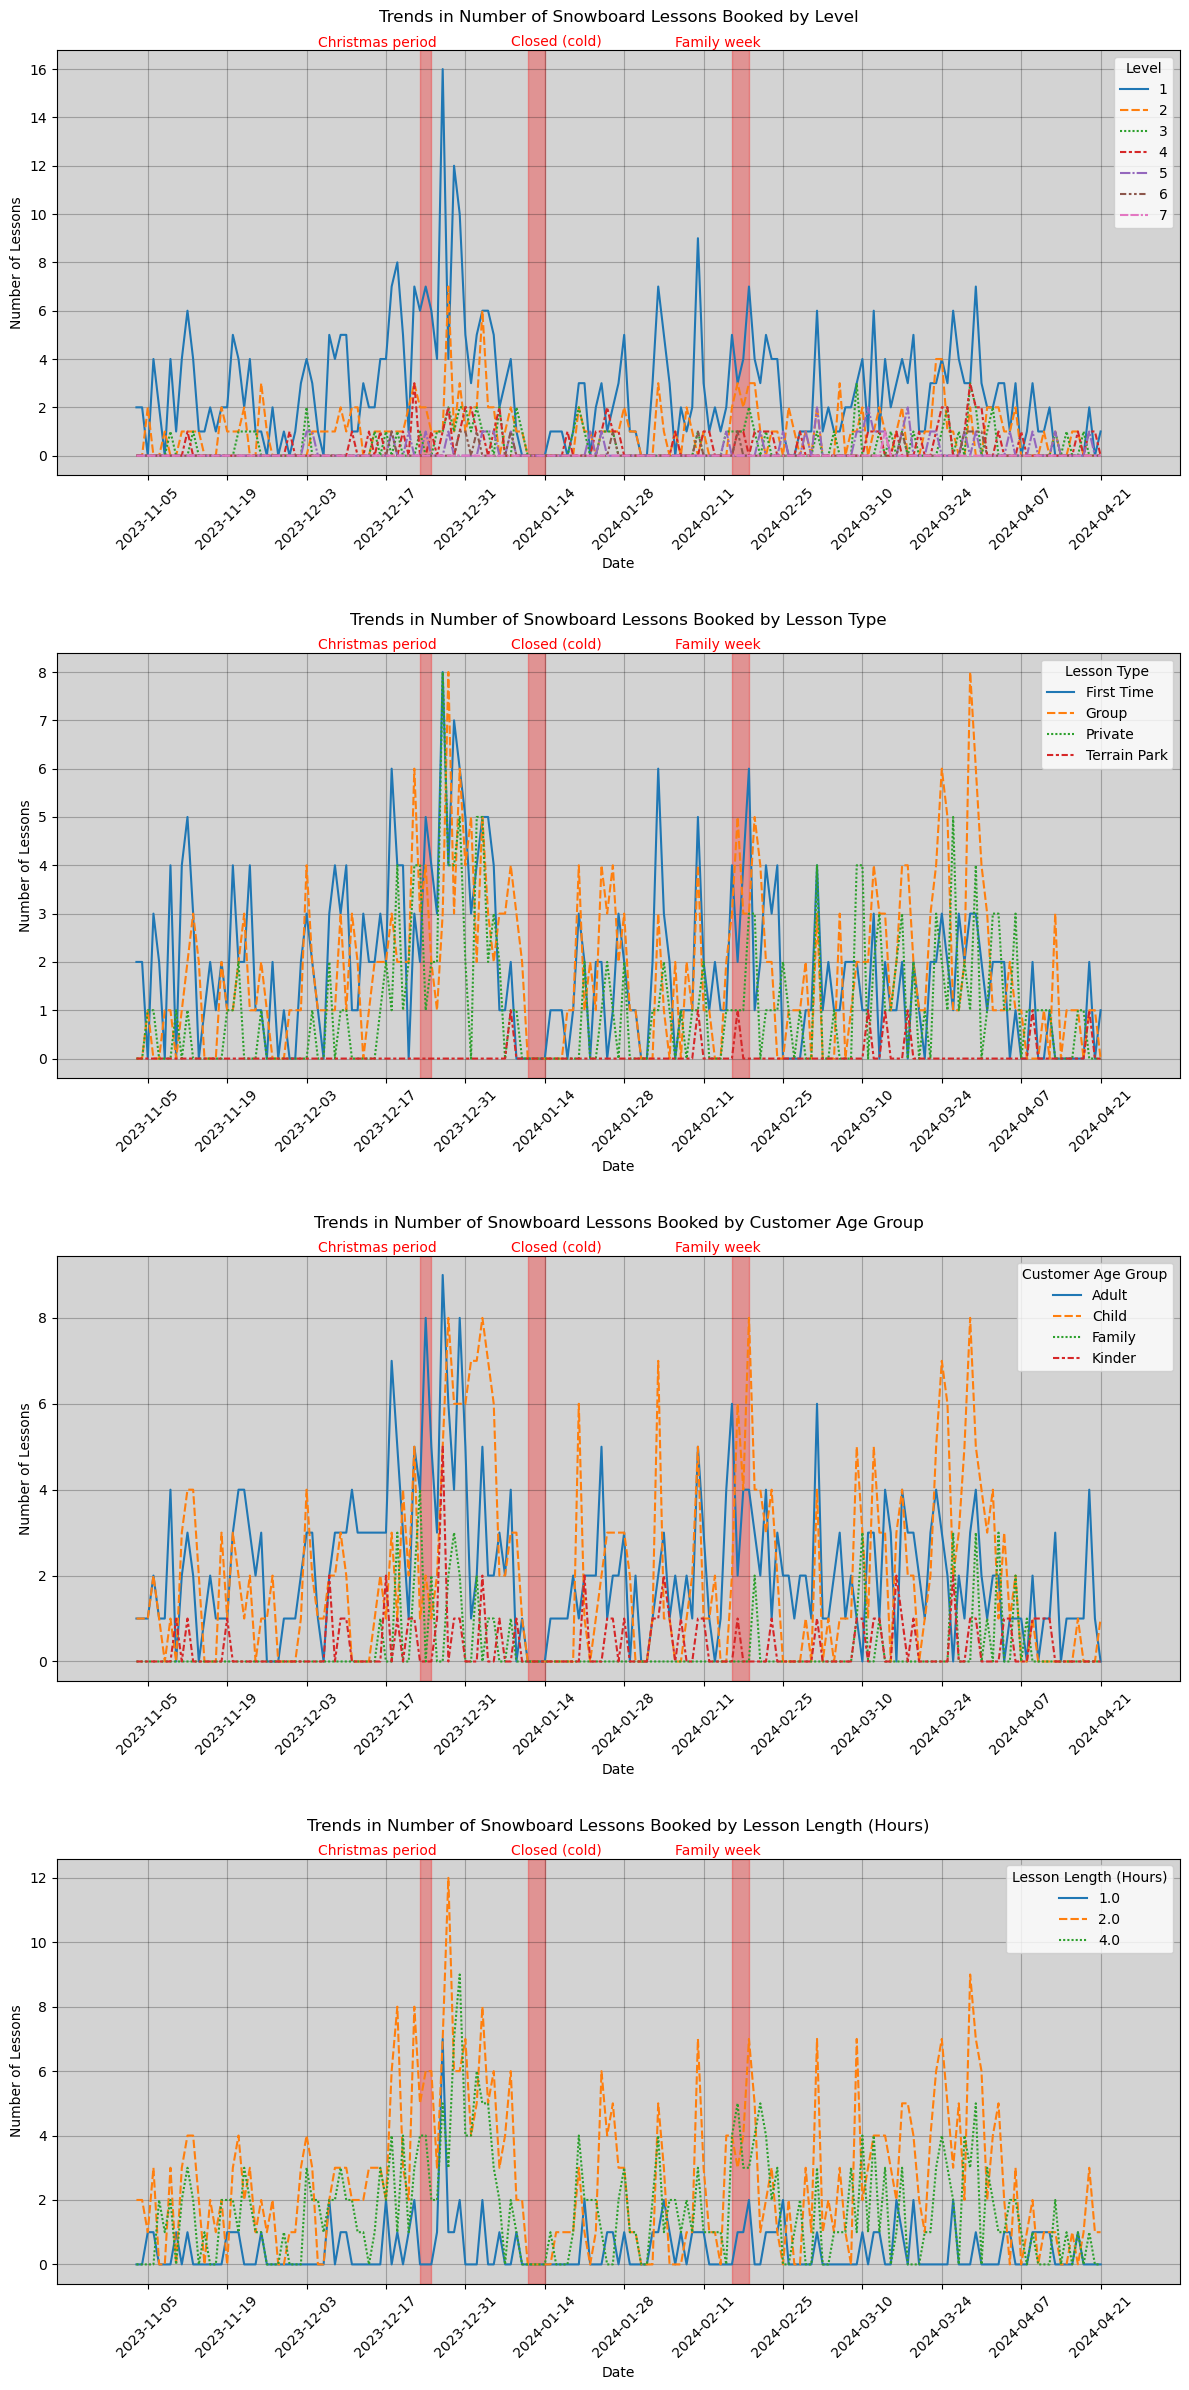

In [69]:
# Filter to just Ski lessons
df_retail_lessons_sbd = df_retail_lessons.loc[df_retail_lessons.loc[:,'Activity'] == 'Snowboard', :]

# Create subplots without sharing x-axis
fig, axes = plt.subplots(len(lesson_variables), 1, figsize=(12, 6 * len(lesson_variables)), sharex=False)

# Plot each variable
for ax, variable in zip(axes, lesson_variables):
    # Group by 'Date' and the variable, then count the number of lessons
    grouped = df_retail_lessons_sbd.groupby([df_retail_lessons_sbd.index, variable]).size().unstack().fillna(0)

    # Reindex to fill missing dates with 0s
    full_date_range = pd.date_range(start=df_retail_lessons_sbd.index.min(), end=df_retail_lessons_sbd.index.max(), freq='D')
    grouped = grouped.reindex(full_date_range, fill_value=0)

    # Plot the data
    sns.lineplot(data=grouped, ax=ax)
    ax.set_title(f'Trends in Number of Snowboard Lessons Booked by {variable}', pad=20)
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Lessons')
    ax.legend(title=variable)

    # Set x-axis limits
    ax.set_xlim(df_retail_lessons_sbd.index[0] + pd.Timedelta(days=-14), df_retail_lessons_sbd.index[-1] + pd.Timedelta(days=14))

    # Draw darker horizontal grid lines manually
    ax.yaxis.grid(True, linestyle='-', color='k', alpha=0.25)
    ax.xaxis.grid(True, linestyle='-', color='k', alpha=0.25)

    # Add a vertical bar for Christmas period
    ax.axvspan(pd.Timestamp('2023-12-23'), pd.Timestamp('2023-12-25'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2023-12-23') - pd.Timedelta(days=18), ax.get_ylim()[1] + (3.5 * ax.get_ylim()[1] / 100), 'Christmas period', color='red', rotation=0, va='top')

    # Add a vertical bar for cold closure
    ax.axvspan(pd.Timestamp('2024-01-11'), pd.Timestamp('2024-01-14'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-01-11') - pd.Timedelta(days=3), ax.get_ylim()[1] + (3.7 * ax.get_ylim()[1] / 100), 'Closed (cold)', color='red', rotation=0, va='top')

    # Add a vertical bar for Family week
    ax.axvspan(pd.Timestamp('2024-02-16'), pd.Timestamp('2024-02-19'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-02-16') - pd.Timedelta(days=10), ax.get_ylim()[1] + (3.5 * ax.get_ylim()[1] / 100), 'Family week', color='red', rotation=0, va='top')

    # Customize the x-ticks for each subplot
    ax.tick_params(axis='x', rotation=45)
    # Set x-ticks for each subplot
    date_range = pd.date_range(start=df_retail_lessons_sbd.index.min(), end=df_retail_lessons_sbd.index.max(), freq='2W')
    ax.set_xticks(date_range)

# Adjust layout with more spacing between subplots
plt.tight_layout(h_pad=3)

# Show the plot
plt.show()

## Generate plots showing booking trends in adult ski lessons

In [71]:
df_retail_lessons_adult_ski

NameError: name 'df_retail_lessons_adult_ski' is not defined

In [ ]:
# Filter to just adult Ski lessons
df_retail_lessons_adult_ski = df_retail_lessons.loc[(df_retail_lessons.loc[:,'Customer Age Group'] == 'Adult') & (df_retail_lessons.loc[:,'Activity'] == 'Ski'), :]
adult_lesson_variables = lesson_variables.copy()
adult_lesson_variables.remove('Customer Age Group')

# Create subplots without sharing x-axis
fig, axes = plt.subplots(len(adult_lesson_variables), 1, figsize=(12, 6 * len(adult_lesson_variables)), sharex=False)

# Plot each variable
for ax, variable in zip(axes, adult_lesson_variables):
    # Group by 'Date' and the variable, then count the number of lessons
    grouped = df_retail_lessons_adult_ski.groupby([df_retail_lessons_adult_ski.index, variable]).size().unstack().fillna(0)

    # Reindex to fill missing dates with 0s
    full_date_range = pd.date_range(start=df_retail_lessons_adult_ski.index.min(), end=df_retail_lessons_adult_ski.index.max(), freq='D')
    grouped = grouped.reindex(full_date_range, fill_value=0)

    # Plot the data
    sns.lineplot(data=grouped, ax=ax)
    ax.set_title(f'Trends in Number of Adult Ski Lessons Booked by {variable}', pad=20)
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Lessons')
    ax.legend(title=variable)

    # Set x-axis limits
    ax.set_xlim(df_retail_lessons_adult_ski.index[0] + pd.Timedelta(days=-14), df_retail_lessons_adult_ski.index[-1] + pd.Timedelta(days=14))

    # Draw darker horizontal grid lines manually
    ax.yaxis.grid(True, linestyle='-', color='k', alpha=0.25)
    ax.xaxis.grid(True, linestyle='-', color='k', alpha=0.25)

    # Add a vertical bar for Christmas period
    ax.axvspan(pd.Timestamp('2023-12-23'), pd.Timestamp('2023-12-25'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2023-12-23') - pd.Timedelta(days=18), ax.get_ylim()[1] + (3.5 * ax.get_ylim()[1] / 100), 'Christmas period', color='red', rotation=0, va='top')

    # Add a vertical bar for cold closure
    ax.axvspan(pd.Timestamp('2024-01-11'), pd.Timestamp('2024-01-14'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-01-11') - pd.Timedelta(days=3), ax.get_ylim()[1] + (3.7 * ax.get_ylim()[1] / 100), 'Closed (cold)', color='red', rotation=0, va='top')

    # Add a vertical bar for Family week
    ax.axvspan(pd.Timestamp('2024-02-16'), pd.Timestamp('2024-02-19'), color='red', alpha=0.3)
    ax.text(pd.Timestamp('2024-02-16') - pd.Timedelta(days=10), ax.get_ylim()[1] + (3.5 * ax.get_ylim()[1] / 100), 'Family week', color='red', rotation=0, va='top')

    # Customize the x-ticks for each subplot
    ax.tick_params(axis='x', rotation=45)
    # Set x-ticks for each subplot
    date_range = pd.date_range(start=df_retail_lessons_adult_ski.index.min(), end=df_retail_lessons_adult_ski.index.max(), freq='2W')
    ax.set_xticks(date_range)

# Adjust layout with more spacing between subplots
plt.tight_layout(h_pad=3)

# Show the plot
plt.show()

## Create plots showing booking trends in adult ski lessons per weekday

In [ ]:
# List of days of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Calculate the number of unique dates for each unique value of 'day_of_week'
df_unique_dates = df_retail_lessons_adult_ski[~df_retail_lessons_adult_ski.index.duplicated(keep='first')]
unique_dates_per_day = df_unique_dates['day_of_week'].value_counts()

# Create subplots
fig, axes = plt.subplots(len(adult_lesson_variables), 1, figsize=(12, 6 * len(adult_lesson_variables)), sharex=False)

# Iterate through each variable
for ax, variable in zip(axes, adult_lesson_variables):
    # Initialize an empty DataFrame to store the average number of lessons
    avg_lessons = pd.DataFrame(index=days_of_week)

    # Iterate through each value of the variable
    for value in df_retail_lessons_adult_ski[variable].unique():
        # Filter the DataFrame for rows with the specific value of the variable
        filtered_df = df_retail_lessons_adult_ski[df_retail_lessons_adult_ski[variable] == value]

        # Calculate the number of lessons for each day of the week
        lessons_per_day = filtered_df.groupby('day_of_week').size()

        # Calculate the average number of lessons per day of the week
        avg_lessons[value] = lessons_per_day / unique_dates_per_day

    # Sort the columns of avg_lessons DataFrame based on their numerical part
    sorted_columns = sorted(avg_lessons.columns, key=lambda x: int(re.findall(r'\d+', str(x))[0]) if re.findall(r'\d+', str(x)) else 0)
    avg_lessons_sorted = avg_lessons[sorted_columns]

    # Plot the data
    avg_lessons_sorted.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title(f'Average Number of Adult Ski Lessons Booked by {variable} per Day of the Week', pad=20)
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel('Average Number of Lessons')
    ax.legend(title=variable)

    # Customize the grid to have vertical grid lines
    ax.yaxis.grid(True, linestyle='-', color='k', alpha=0.25)
    ax.xaxis.grid(True, linestyle='-', color='k', alpha=0.25)

    # Customize the x-ticks for each subplot
    ax.tick_params(axis='x', rotation=45)

# Adjust layout with more spacing between subplots
plt.tight_layout(h_pad=3)

# Show the plot
plt.show()
